In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import os

#tensorflow keras imports
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping

2024-04-12 00:07:07.475408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 00:07:07.475443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 00:07:07.497787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 00:07:07.544130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [4]:
from utils import *
import pickle

mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    mu_t2 = 0.
    sd_m = 0.
    sd_t = 0.
    sd_t2 = 0.
    
    mj1_list = []
    mj2_list = []

    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq','qqq']:

                print("on ...",m1,m2,qq)

                ltau1_m_m = []
                ltau2_m_m = []
                ltau3_m_m = []
                stau1_m_m = []
                stau2_m_m = []
                stau3_m_m = []
                if (m1>0 and m2>0):
                    myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq_fixed/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    if (qq=='qqq'):
                        myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qqq_fixed/LHCO_RnD_qqq2_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    jets_m_m = []
                    for line in myfile:
                        jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                        pass
                    ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                    sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                    lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                    smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.
                    
                    #check ordering of the leading and subleading jets
                    #if leading jet mm > subleading, continue
                    #if leading jet mm < subleading, swap
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]

                    ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    ltau3_m_m = np.array([float(ljet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    stau3_m_m = np.array([float(sjet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    mjj = computemjj_txt(jets_m_m)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]
                    pass
                elif m1==0 and m2==0:
                    df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                    df_extra_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_qcd_extra_inneronly_features.h5")
                    df_QCD = pd.concat([df_QCD, df_extra_QCD], axis=0)
                    
                    lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                    smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                    
                    #check jet ordering
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                    ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                    ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                    ltau3_m_m = np.array(df_QCD[["tau3j1"]]).flatten()
                    stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                    stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                    stau3_m_m = np.array(df_QCD[["tau3j2"]]).flatten()
                    mjj = computemjj_pd(df_QCD)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]

                    mu_m = np.mean(lmass_m_m)
                    mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                    mu_t2 = np.mean(ltau3_m_m/(ltau2_m_m+0.0001))
                    sd_m = np.std(lmass_m_m)
                    sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                    sd_t2 = np.std(ltau3_m_m/(ltau2_m_m+0.0001))
                    pass
                else:
                    continue

                ms = np.stack([lmass_m_m,smass_m_m],axis=1)
                ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
                ts2 = np.stack([ltau3_m_m/(ltau2_m_m+0.0001),stau3_m_m/(stau2_m_m+0.001)],axis=1)
                order1 = [np.argmax(ms[i]) for i in range(len(ms))]
                order2 = [np.argmin(ms[i]) for i in range(len(ms))]
                mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
                mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
                
                mj1_list.append(mJ1)
                mj2_list.append(mJ2)
                x[m1,m2,qq] = np.stack([(mJ2 - mu_m)/sd_m,
                                        ((mJ1 - mJ2) - mu_m)/sd_m,
                                        (np.array([ts[i][order2[i]] for i in range(len(ts))]) - mu_t)/sd_t,
                                        (np.array([ts[i][order1[i]] for i in range(len(ts))]) - mu_t)/sd_t,
                                        (np.array([ts2[i][order2[i]] for i in range(len(ts2))]) - mu_t2)/sd_t2,
                                        (np.array([ts2[i][order1[i]] for i in range(len(ts2))]) - mu_t2)/sd_t2],axis=1)
                lmass_vec[m1,m2]=lmass_m_m
                pass
            pass
        pass
    
    #mj2, deltamjj, tau21j2, tau21j1, tau32j2, tau32j1
    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array+=[x[m1,m2,qq]]
    # with open("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", "wb") as f:
    #     pickle.dump(x_array, f)

In [77]:
# with open("/pscratch/sd/g/gupsingh/x_array_fixed_EXTRAQCD.pkl", "wb") as f:
#         pickle.dump(x_array, f)

In [2]:
qq = "qq"
qqq = "qqq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
def load_data(filename, noise_dims):
    x = {}
    x_array_read = np.load(filename,allow_pickle=True)
    mycounter = -1
    for m1 in mass_range:
        for m2 in mass_range:
            for q in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                mycounter+=1
                x[m1,m2,q, False] = x_array_read[mycounter]

                if noise_dims and qq == "qq":
                    for i in range(noise_dims):
                        noise_feature = np.random.normal(0, 1, len(x[m1,m2,qq, False])).reshape(-1, 1)
                        if i == 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, False], noise_feature))
                        if i > 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, True], noise_feature))
    
    return x
x = load_data("/pscratch/sd/g/gupsingh/x_array_fixed_EXTRAQCD.pkl", noise_dims = 0)
#x = load_data("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", noise_dims = 0)

In [17]:
np.shape(x[0,0,qq,False])

(734210, 7)

In [3]:
x_data_qq_23 = []
x_data_qqq_23 = []
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        x_data_qq_23.extend(x[m1, m2, qq, False])
        x_data_qqq_23.extend(x[m1, m2, qqq, False])

In [5]:
#try FS with 2+3 prong information
noise = False
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
qq = "qq"
qqq = "qqq"
feature_dims = 6
x_data_23 = np.concatenate([x_data_qq_23, x_data_qqq_23])
y_data_23 = np.concatenate([np.zeros(len(x_data_qq_23)), np.ones(len(x_data_qqq_23))])
X_train_23, X_val_23, Y_train_23, Y_val_23 = train_test_split(x_data_23, y_data_23, test_size=0.5)

model23 = Sequential()
model23.add(Dense(256, input_dim=feature_dims, activation='relu'))
model23.add(Dense(128, activation='relu'))
model23.add(Dense(64, activation='relu'))
model23.add(Dense(1, activation='sigmoid'))
model23.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

myhistory23 = model23.fit(X_train_23, Y_train_23, epochs=1000, validation_data=(X_val_23, Y_val_23),batch_size=1024, callbacks = [es])

2024-04-10 13:30:16.321918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37185 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Epoch 1/1000


2024-04-10 13:30:22.910540: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd8ec0b5bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 13:30:22.910573: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-04-10 13:30:22.975074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 13:30:23.188720: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
I0000 00:00:1712781023.415559 1076505 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9696/9696 [==============================] - 63s 6ms/step - loss: 0.6204 - accuracy: 0.6546 - val_loss: 0.6193 - val_accuracy: 0.6556
Epoch 2/1000
9696/9696 [==============================] - 48s 5ms/step - loss: 0.6194 - accuracy: 0.6553 - val_loss: 0.6189 - val_accuracy: 0.6558
Epoch 3/1000
9696/9696 [==============================] - 50s 5ms/step - loss: 0.6192 - accuracy: 0.6555 - val_loss: 0.6189 - val_accuracy: 0.6557
Epoch 4/1000
9696/9696 [==============================] - 51s 5ms/step - loss: 0.6191 - accuracy: 0.6557 - val_loss: 0.6189 - val_accuracy: 0.6557
Epoch 5/1000
9696/9696 [==============================] - 50s 5ms/step - loss: 0.6190 - accuracy: 0.6557 - val_loss: 0.6195 - val_accuracy: 0.6556
Epoch 6/1000
9696/9696 [==============================] - 47s 5ms/step - loss: 0.6190 - accuracy: 0.6558 - val_loss: 0.6188 - val_accuracy: 0.6558
Epoch 7/1000
9696/9696 [==============================] - 49s 5ms/step - loss: 0.6189 - accuracy: 0.6559 - val_loss: 0.6189 - val_a

In [6]:
#model23.save("/pscratch/sd/g/gupsingh/" + "model23")

INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model23/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model23/assets


In [7]:
model23(x[0, 0, qq, False])

<tf.Tensor: shape=(734210, 1), dtype=float32, numpy=
array([[0.5639016 ],
       [0.70766455],
       [0.62225634],
       ...,
       [0.46276027],
       [0.6564642 ],
       [0.6996115 ]], dtype=float32)>

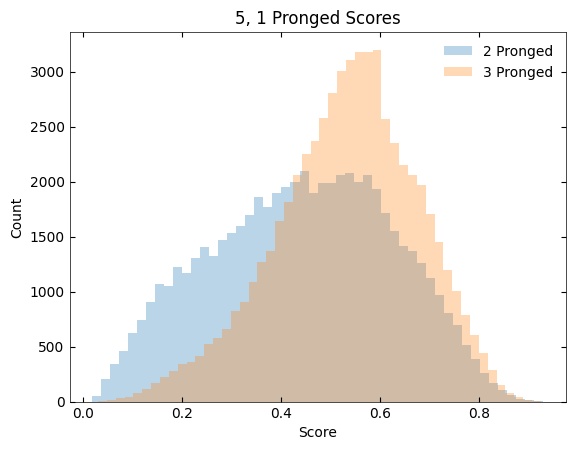

In [33]:
m1,m2 = 5, 1
model23 = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/" + "model23")
plt.hist(model23(x[m1, m2, qq, False]).numpy(), label = "2 Pronged", bins = 50, alpha = 0.3)
plt.hist(model23(x[m1, m2, qqq, False]).numpy(), label = "3 Pronged", bins = 50, alpha = 0.3)
plt.legend(loc="upper right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.xlabel("Score")
plt.ylabel("Count")
plt.title(f"{m1}, {m2} Pronged Scores")
plt.show()

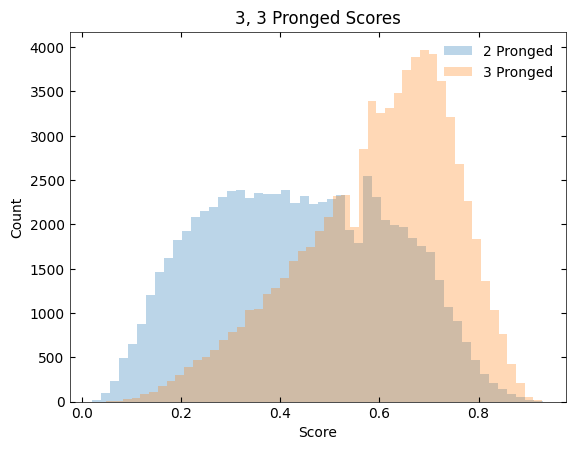

In [34]:
m1,m2 = 3, 3
model23 = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/" + "model23")
plt.hist(model23(x[m1, m2, qq, False]).numpy(), label = "2 Pronged", bins = 50, alpha = 0.3)
plt.hist(model23(x[m1, m2, qqq, False]).numpy(), label = "3 Pronged", bins = 50, alpha = 0.3)
plt.legend(loc="upper right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.xlabel("Score")
plt.ylabel("Count")
plt.title(f"{m1}, {m2} Pronged Scores")
plt.show()

In [3]:
noise = False
model23 = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/" + "model23")

for m1 in mass_range:
    for m2 in mass_range:
        for qq in ["qq","qqq"]:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            print(m1,m2)
            x[m1,m2, qq, noise] = np.hstack((x[m1, m2, qq, noise], model23(x[m1, m2, qq, noise]).numpy()))

2024-04-12 00:07:34.707523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38384 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


0 0
0 0
0.5 0.5
0.5 0.5
0.5 1
0.5 1
0.5 1.5
0.5 1.5
0.5 2
0.5 2
0.5 2.5
0.5 2.5
0.5 3
0.5 3
0.5 3.5
0.5 3.5
0.5 4
0.5 4
0.5 4.5
0.5 4.5
0.5 5
0.5 5
0.5 5.5
0.5 5.5
0.5 6
0.5 6
1 0.5
1 0.5
1 1
1 1
1 1.5
1 1.5
1 2
1 2
1 2.5
1 2.5
1 3
1 3
1 3.5
1 3.5
1 4
1 4
1 4.5
1 4.5
1 5
1 5
1 5.5
1 5.5
1 6
1 6
1.5 0.5
1.5 0.5
1.5 1
1.5 1
1.5 1.5
1.5 1.5
1.5 2
1.5 2
1.5 2.5
1.5 2.5
1.5 3
1.5 3
1.5 3.5
1.5 3.5
1.5 4
1.5 4
1.5 4.5
1.5 4.5
1.5 5
1.5 5
1.5 5.5
1.5 5.5
1.5 6
1.5 6
2 0.5
2 0.5
2 1
2 1
2 1.5
2 1.5
2 2
2 2
2 2.5
2 2.5
2 3
2 3
2 3.5
2 3.5
2 4
2 4
2 4.5
2 4.5
2 5
2 5
2 5.5
2 5.5
2 6
2 6
2.5 0.5
2.5 0.5
2.5 1
2.5 1
2.5 1.5
2.5 1.5
2.5 2
2.5 2
2.5 2.5
2.5 2.5
2.5 3
2.5 3
2.5 3.5
2.5 3.5
2.5 4
2.5 4
2.5 4.5
2.5 4.5
2.5 5
2.5 5
2.5 5.5
2.5 5.5
2.5 6
2.5 6
3 0.5
3 0.5
3 1
3 1
3 1.5
3 1.5
3 2
3 2
3 2.5
3 2.5
3 3
3 3
3 3.5
3 3.5
3 4
3 4
3 4.5
3 4.5
3 5
3 5
3 5.5
3 5.5
3 6
3 6
3.5 0.5
3.5 0.5
3.5 1
3.5 1
3.5 1.5
3.5 1.5
3.5 2
3.5 2
3.5 2.5
3.5 2.5
3.5 3
3.5 3
3.5 3.5
3.5 3.5
3.5 4
3.5 4
3.5 4.5
3.5 4.5


In [5]:
np.shape(x[5, 1, qq, False])

(59338, 7)

Text(0.5, 0, 'tau32j1')

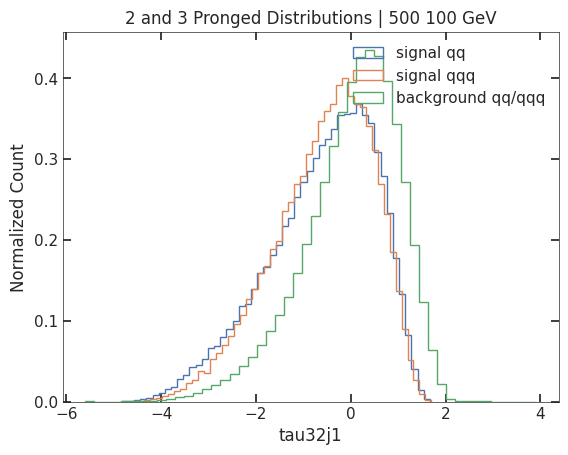

In [34]:
import seaborn as sns
sns.set(style="white")
plt.figure()
plt.title("2 and 3 Pronged Distributions | 500 100 GeV")
plt.hist(x[5,1, qq, False][:,5], bins = 50, alpha = 1, density = True, label = "signal qq", histtype="step");
plt.hist(x[5,1, qqq, False][:,5], bins = 50, alpha = 1, density = True, label = "signal qqq", histtype="step");
plt.hist(x[0,0, qqq, False][:,5], bins = 50, alpha = 1, density = True, label = "background qq/qqq", histtype="step");
plt.legend(loc="upper right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.ylabel("Normalized Count")
plt.xlabel("tau32j1")

Text(0.5, 0, 'tau32j1')

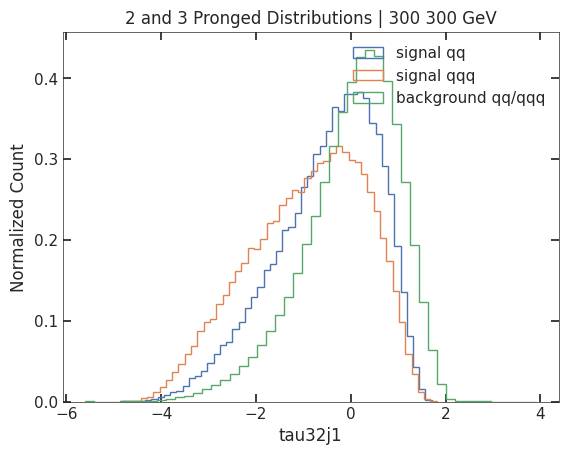

In [35]:
plt.figure()
plt.title("2 and 3 Pronged Distributions | 300 300 GeV")
plt.hist(x[3,3, qq, False][:,5], bins = 50, alpha = 1, density = True, label = "signal qq", histtype="step");
plt.hist(x[3,3, qqq, False][:,5], bins = 50, alpha = 1, density = True, label = "signal qqq", histtype="step");
plt.hist(x[0,0, qqq, False][:,5], bins = 50, alpha = 1, density = True, label = "background qq/qqq", histtype="step");
plt.legend(loc="upper right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.ylabel("Normalized Count")
plt.xlabel("tau32j1")

In [3]:
np.shape(x[0,0, qq, True])

(734210, 56)

In [22]:
np.shape(x[0,0, qq, False])

(734210, 6)

In [3]:
np.shape(x[0,0, qqq, False])

(734210, 6)

In [7]:
x_data_qq = []
y_data_qq = []
qq = "qq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
noise = False
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        for qq in ['qq']:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0,qq, noise],m1*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2,qq, noise],m1*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_data_qq = np.concatenate([x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_data_qq = np.concatenate([x_data_qq,x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([y_data_qq,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [9]:
np.shape(x_data_qq)

(115500407, 9)

In [10]:
np.save("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_extra_23score", x_data_qq)
np.save("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_extra_23score", y_data_qq)

In [23]:
x_data_qqq = []
y_data_qqq = []
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
noise = False
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        for qq in ['qqq']:
            qq = "qqq"
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0,qq, noise],m1*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2,qq, noise],m1*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_data_qqq = np.concatenate([x_aug_0,x_aug_m])
                y_data_qqq = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_data_qqq = np.concatenate([x_data_qqq,x_aug_0,x_aug_m])
                y_data_qqq = np.concatenate([y_data_qqq,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [24]:
# np.save("/pscratch/sd/g/gupsingh/x_parametrized_data_qqq_extra_23score", x_data_qqq)
# np.save("/pscratch/sd/g/gupsingh/y_parametrized_data_qqq_extra_23score", y_data_qqq)

In [9]:
# np.save("/pscratch/sd/g/gupsingh/x_parametrized_data_qqq_fixed", x_data_qqq)
# np.save("/pscratch/sd/g/gupsingh/y_parametrized_data_qqq_fixed", y_data_qqq)

In [25]:
x_data_qq = np.load("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_extra.npy")
y_data_qq = np.load("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_extra.npy")

In [12]:
x_data_qq

array([[-1.51644365, -0.61383926, -1.38883549, ...,  1.3241429 ,
         0.5       ,  0.5       ],
       [-1.36719444, -1.69813041,  0.49104722, ...,  0.3930433 ,
         0.5       ,  0.5       ],
       [-0.91168934, -1.71387529,  1.15976908, ...,  0.62847367,
         0.5       ,  0.5       ],
       ...,
       [ 0.42602584, -0.52825921, -2.1769752 , ...,  0.29634498,
         6.        ,  6.        ],
       [ 1.6563657 , -1.49343627, -1.84191338, ..., -0.11969756,
         6.        ,  6.        ],
       [ 1.30028397, -1.67465397, -2.52146522, ...,  0.71570313,
         6.        ,  6.        ]])

In [9]:
x_data_qq = np.load("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_extra_noise20.npy")
y_data_qq = np.load("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_extra_noise20.npy")

In [36]:
x_data_qq = np.load("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_extra_23score.npy")
y_data_qq = np.load("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_extra_23score.npy")

In [38]:
x_data_qq[:,np.shape(x_data_qq)[1]-2:np.shape(x_data_qq)[1]]

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       ...,
       [6. , 6. ],
       [6. , 6. ],
       [6. , 6. ]])

In [10]:
noise_dims_add = 10
noise_dims_remove = [i for i in range(np.shape(x_data_qq)[1] - (3 + noise_dims_add), 5, -1)]
x_data_qq = np.delete(x_data_qq, noise_dims_remove, axis = 1)
np.shape(x_data_qq)

(115500407, 18)

In [26]:
x_data_qqq = np.load("/pscratch/sd/g/gupsingh/x_parametrized_data_qqq_extra.npy")
y_data_qqq = np.load("/pscratch/sd/g/gupsingh/y_parametrized_data_qqq_extra.npy")

In [5]:
x_data_qqq = np.load("/pscratch/sd/g/gupsingh/x_parametrized_data_qqq_extra_23score.npy")
y_data_qqq = np.load("/pscratch/sd/g/gupsingh/y_parametrized_data_qqq_extra_23score.npy")

In [3]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_data_qq, y_data_qq, test_size=0.5, random_state = 42)

In [26]:
np.shape(X_train_qq)

(57750203, 9)

In [6]:
X_train_qqq, X_val_qqq, Y_train_qqq, Y_val_qqq = train_test_split(x_data_qqq, y_data_qqq, test_size=0.5, random_state = 42)

793/793 [==============================] - 1s 789us/step
AUC: 0.9822237803725569


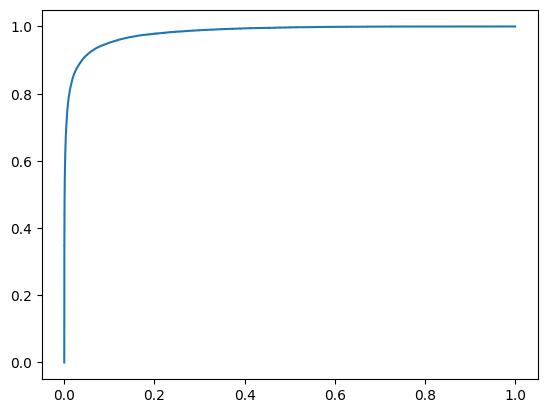

In [34]:
preds_qq = model_qq.predict(x_data_qq[np.prod(x_data_qq[:,6:8]==[5,1],axis=1)==1],batch_size=1000)
fpr_qq, tpr_qq, _ = metrics.roc_curve(y_data_qq[np.prod(x_data_qq[:,6:8]==[5,1],axis=1)==1], preds_qq)
plt.plot(fpr_qq, tpr_qq)
auc = calculate_auc(fpr_qq, tpr_qq)
print("AUC:", auc)

In [35]:
preds_qq = model_qq.predict(x_data_qqq[np.prod(x_data_qqq[:,7:9]==[5,1],axis=1)==1],batch_size=1000)
fpr_qq, tpr_qq, _ = metrics.roc_curve(y_data_qqq[np.prod(x_data_qqq[:,7:9]==[5,1],axis=1)==1], preds_qq)
plt.plot(fpr_qq, tpr_qq)
auc = calculate_auc(fpr_qq, tpr_qq)
print("AUC:", auc)

794/794 [==============================] - 1s 690us/step
AUC: 0.9713581390849801


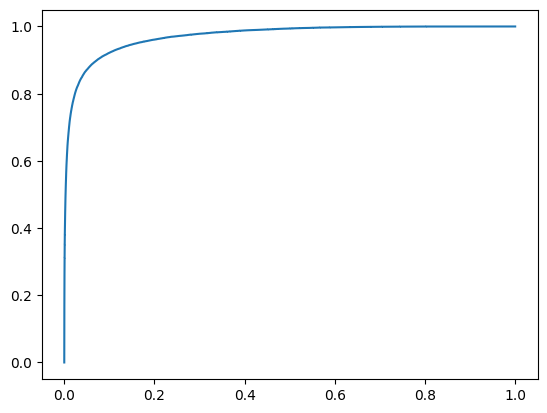

In [44]:
def calculate_auc(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]
    
    auc = np.trapz(tpr_sorted, fpr_sorted)
    return auc

preds_qqq = model_qq.predict(x_data_qqq[np.prod(x_data_qqq[:,7:9]==[5,1],axis=1)==1],batch_size=1000)
fpr_qqq, tpr_qqq, _ = metrics.roc_curve(y_data_qqq[np.prod(x_data_qqq[:,7:9]==[5,1],axis=1)==1], preds_qqq)
plt.plot(fpr_qqq, tpr_qqq)
auc = calculate_auc(fpr_qqq, tpr_qqq)
print("AUC:", auc)

In [7]:
np.shape(X_train_qq)

(57750203, 18)

In [11]:
# x_data_qqq = np.load("x_data_qqq.npy")
# y_data_qqq = np.load("y_data_qqq.npy")

In [31]:
np.array_equal(x_data_qq[:, :6], x_data_qq_reduced[:, :6])

True

In [8]:
import wandb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from wandb.keras import WandbCallback

noise_dims = 0
pscratch_dir = "/pscratch/sd/g/gupsingh/"
os.environ["WANDB_DIR"] = pscratch_dir

config = {
    "layer_1_neurons": 256,
    "layer_2_neurons": 128,
    "layer_3_neurons": 64,
    "output_neurons": 1,
    "activation": "relu",
    "output_activation": "sigmoid",
    "optimizer": "adam",
    "learning_rate": 0.001,
    "loss": "binary_crossentropy",
    "epochs": 5000,
    "batch_size": 1024
}

wandb.init(project="SemiWeakly", 
           group="Parametrized", 
           entity='gup-singh',
           mode = 'online',
           config=config)

config = wandb.config
run_name = wandb.run.name

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

def train_parametrized(X_train, Y_train, X_val, Y_val, config, return_history=False):
    model_parametrized = Sequential()
    model_parametrized.add(Dense(config["layer_1_neurons"], input_dim=np.shape(X_train)[1], activation=config["activation"]))
    model_parametrized.add(Dropout(0.5))
    model_parametrized.add(Dense(config["layer_2_neurons"], activation=config["activation"]))
    model_parametrized.add(Dropout(0.5))
    model_parametrized.add(Dense(config["layer_3_neurons"], activation=config["activation"]))
    model_parametrized.add(Dense(config.output_neurons, activation=config["output_activation"]))
    model_parametrized.compile(loss=config["loss"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]), metrics=['accuracy'])

    with tf.device('/GPU:0'):
        history_parametrized = model_parametrized.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), batch_size=config.batch_size, callbacks=[es, WandbCallback()])
    
    if return_history:
        return model_parametrized, history_parametrized
    else:
        return model_parametrized

model_parametrized, history_parametrized = train_parametrized(X_train_qqq, Y_train_qqq, X_val_qqq, Y_val_qqq, config, return_history=True)

wandb.finish()

model_parametrized.save(pscratch_dir + run_name + f"qqq{noise_dims}23")
#model_parametrized.save(pscratch_dir+"normal")

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▇▇▇▇█████
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▄▃▂▂▂▂▁▁▁▁▁
val_accuracy,▅▇▄▆█▆▁▆▇▁█▁
val_loss,▃▂▃▁▁▂▇▃▃█▃█
accuracy,0.96946
best_epoch,4
best_val_loss,0.08289
epoch,11
loss,0.08294
val_accuracy,0.96862


Epoch 1/5000
56542/56548 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.9654

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best)... Done. 0.1s


56548/56548 [==============================] - 157s 3ms/step - loss: 0.0961 - accuracy: 0.9654 - val_loss: 0.0889 - val_accuracy: 0.9689
Epoch 2/5000
56546/56548 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9671

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best)... Done. 0.0s


56548/56548 [==============================] - 152s 3ms/step - loss: 0.0910 - accuracy: 0.9671 - val_loss: 0.0874 - val_accuracy: 0.9691
Epoch 3/5000
56536/56548 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9675

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best)... Done. 0.0s


56548/56548 [==============================] - 152s 3ms/step - loss: 0.0898 - accuracy: 0.9675 - val_loss: 0.0847 - val_accuracy: 0.9693
Epoch 4/5000
56548/56548 [==============================] - 151s 3ms/step - loss: 0.0890 - accuracy: 0.9678 - val_loss: 0.0865 - val_accuracy: 0.9694
Epoch 5/5000
56548/56548 [==============================] - 151s 3ms/step - loss: 0.0885 - accuracy: 0.9679 - val_loss: 0.0866 - val_accuracy: 0.9694
Epoch 6/5000
56548/56548 [==============================] - 150s 3ms/step - loss: 0.0882 - accuracy: 0.9680 - val_loss: 0.0864 - val_accuracy: 0.9693
Epoch 7/5000
56548/56548 [==============================] - 151s 3ms/step - loss: 0.0879 - accuracy: 0.9681 - val_loss: 0.0869 - val_accuracy: 0.9690
Epoch 8/5000
56534/56548 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9681

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best)... Done. 0.0s


56548/56548 [==============================] - 151s 3ms/step - loss: 0.0877 - accuracy: 0.9681 - val_loss: 0.0843 - val_accuracy: 0.9696
Epoch 9/5000
56548/56548 [==============================] - 151s 3ms/step - loss: 0.0875 - accuracy: 0.9682 - val_loss: 0.0853 - val_accuracy: 0.9697
Epoch 10/5000
56548/56548 [==============================] - 151s 3ms/step - loss: 0.0873 - accuracy: 0.9682 - val_loss: 0.0853 - val_accuracy: 0.9697
Epoch 11/5000
56548/56548 [==============================] - 153s 3ms/step - loss: 0.0872 - accuracy: 0.9683 - val_loss: 0.0851 - val_accuracy: 0.9694
Epoch 12/5000
56544/56548 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9683

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best)... Done. 0.1s


56548/56548 [==============================] - 154s 3ms/step - loss: 0.0871 - accuracy: 0.9683 - val_loss: 0.0843 - val_accuracy: 0.9696
Epoch 13/5000
56548/56548 [==============================] - 151s 3ms/step - loss: 0.0870 - accuracy: 0.9684 - val_loss: 0.0857 - val_accuracy: 0.9693
Epoch 14/5000
56548/56548 [==============================] - 149s 3ms/step - loss: 0.0869 - accuracy: 0.9684 - val_loss: 0.0845 - val_accuracy: 0.9699
Epoch 15/5000
56548/56548 [==============================] - 149s 3ms/step - loss: 0.0868 - accuracy: 0.9684 - val_loss: 0.0847 - val_accuracy: 0.9696
Epoch 16/5000
56548/56548 [==============================] - 148s 3ms/step - loss: 0.0867 - accuracy: 0.9684 - val_loss: 0.0848 - val_accuracy: 0.9697
Epoch 17/5000
56533/56548 [============================>.] - ETA: 0s - loss: 0.0867 - accuracy: 0.9685

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best)... Done. 0.0s


56548/56548 [==============================] - 149s 3ms/step - loss: 0.0867 - accuracy: 0.9685 - val_loss: 0.0839 - val_accuracy: 0.9699
Epoch 18/5000
56538/56548 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.9685

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best)... Done. 0.0s


56548/56548 [==============================] - 148s 3ms/step - loss: 0.0866 - accuracy: 0.9685 - val_loss: 0.0835 - val_accuracy: 0.9698
Epoch 19/5000
56548/56548 [==============================] - 147s 3ms/step - loss: 0.0865 - accuracy: 0.9685 - val_loss: 0.0852 - val_accuracy: 0.9697
Epoch 20/5000
56548/56548 [==============================] - 148s 3ms/step - loss: 0.0865 - accuracy: 0.9685 - val_loss: 0.0853 - val_accuracy: 0.9699
Epoch 21/5000
56548/56548 [==============================] - 148s 3ms/step - loss: 0.0865 - accuracy: 0.9685 - val_loss: 0.0853 - val_accuracy: 0.9697
Epoch 22/5000
56537/56548 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9685

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240411_104033-a4uswu70/files/model-best)... Done. 0.0s


56548/56548 [==============================] - 149s 3ms/step - loss: 0.0864 - accuracy: 0.9685 - val_loss: 0.0832 - val_accuracy: 0.9698
Epoch 23/5000
56548/56548 [==============================] - 148s 3ms/step - loss: 0.0864 - accuracy: 0.9686 - val_loss: 0.0839 - val_accuracy: 0.9699
Epoch 24/5000
56548/56548 [==============================] - 148s 3ms/step - loss: 0.0864 - accuracy: 0.9686 - val_loss: 0.0845 - val_accuracy: 0.9697
Epoch 25/5000
56548/56548 [==============================] - 147s 3ms/step - loss: 0.0863 - accuracy: 0.9686 - val_loss: 0.0848 - val_accuracy: 0.9696
Epoch 26/5000
56548/56548 [==============================] - 148s 3ms/step - loss: 0.0863 - accuracy: 0.9686 - val_loss: 0.0852 - val_accuracy: 0.9698
Epoch 27/5000
56548/56548 [==============================] - 149s 3ms/step - loss: 0.0863 - accuracy: 0.9686 - val_loss: 0.0852 - val_accuracy: 0.9697
Epoch 28/5000
56548/56548 [==============================] - 148s 3ms/step - loss: 0.0863 - accuracy: 0.9686

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▄▄▂▆▇▇▅▆▄█▆▆█▇▆█▇▇█▇▆▇▇▅▇█▅▇
val_loss,█▆▃▅▅▅▆▂▄▃▃▂▄▃▃▃▂▁▃▃▄▁▂▃▃▃▃▅▂▃▅▃
accuracy,0.96863
best_epoch,21
best_val_loss,0.08323
epoch,31
loss,0.08623
val_accuracy,0.96971


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/pious-bee-128qqq023/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/pious-bee-128qqq023/assets


In [28]:
x[0,0,qq, False][:,6]

array([0.5639016 , 0.70766455, 0.62225634, ..., 0.46276027, 0.65646422,
       0.69961149])

In [29]:
x[5,1,qq, False][:,6]

array([0.66670555, 0.072854  , 0.39295483, ..., 0.27754888, 0.56837332,
       0.24128598])

In [19]:
# num_epochs = len(history_parametrized.history["loss"])
# send_slack_message(f"Notebook Parametrized Training Finished - Epochs: {num_epochs}")

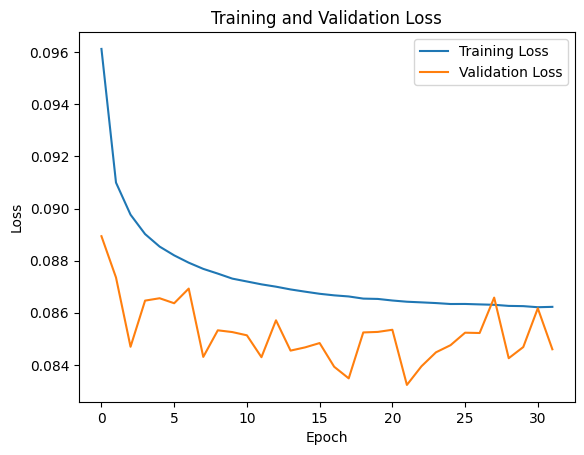

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/slack_sdk/web/internal_utils.py:417: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)


Plot sent successfully: None


In [9]:
#Diagonistic Plot
plt.figure()
plt.plot(history_parametrized.history['loss'], label='Training Loss')
plt.plot(history_parametrized.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
img_path = "plots/parametrized_trainingloss.png"
plt.savefig(img_path)
plt.legend()
plt.show()

from utils import send_slack_plot
send_slack_plot(img_path)

In [29]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.94709
best_epoch,41
best_val_loss,0.13607
epoch,41
loss,0.1365
val_accuracy,0.94731


In [15]:
#model_qq.save(pscratch_dir + "model_fixed")

INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model_fixed/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model_fixed/assets


In [12]:
np.shape(x_data_qq)

(115500407, 13)

In [32]:
from tensorflow.keras.layers import Dropout
noise_dims = 10
x = load_data("/pscratch/sd/g/gupsingh/x_array_fixed_EXTRAQCD.pkl", noise_dims = noise_dims)

preds_mm_list = []
tuple_rates_dedicated_benchmark_extra = {}
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
qq = "qq"

if noise_dims == 0:
    noise = False
else:
    noise = True
print(noise)
feature_dims = 6 + noise_dims
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        if (m1 == 5 and m2 == 1) or (m1 == 3 and m2 == 3) or (m1 == 1 and m2 == 1) or (m1 == 1 and m2 == 5):
            x_data_mm = np.concatenate([x[0,0, qq, noise],x[m1,m2, qq, noise]])
            y_data_mm = np.concatenate([np.zeros(len(x[0,0, qq, noise])),np.ones(len(x[m1,m2, qq, noise]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_data_mm, y_data_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(256, input_dim=feature_dims, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(128, activation='relu'))
            #model.add(Dropout(0.5))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            tuple_rates_dedicated_benchmark_extra[tuple((m1, m2))] = [fpr_mm, tpr_mm]
            
np.save(f"tuple_rates_dedicated_benchmark_extra{qq}{noise_dims}.npy", tuple_rates_dedicated_benchmark_extra)

True
Epoch 1/1000
396/396 [==============================] - 2s 3ms/step - loss: 0.1624 - accuracy: 0.9387 - val_loss: 0.1118 - val_accuracy: 0.9583
Epoch 2/1000
396/396 [==============================] - 1s 4ms/step - loss: 0.1093 - accuracy: 0.9593 - val_loss: 0.0946 - val_accuracy: 0.9652
Epoch 3/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0963 - accuracy: 0.9647 - val_loss: 0.0862 - val_accuracy: 0.9681
Epoch 4/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0887 - accuracy: 0.9676 - val_loss: 0.0809 - val_accuracy: 0.9698
Epoch 5/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0852 - accuracy: 0.9685 - val_loss: 0.0789 - val_accuracy: 0.9705
Epoch 6/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0826 - accuracy: 0.9694 - val_loss: 0.0785 - val_accuracy: 0.9707
Epoch 7/1000
396/396 [==============================] - 1s 3ms/step - loss: 0.0817 - accuracy: 0.9698 - val_loss: 0.0775 - val_accu

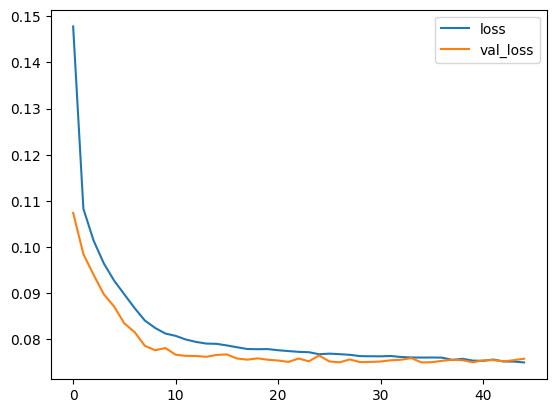

In [33]:
epochs = [i for i in range(len(myhistory.history["loss"]))]
plt.plot(epochs, myhistory.history["loss"], label = "loss")
plt.plot(epochs, myhistory.history["val_loss"], label = "val_loss")
plt.legend()

(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 7.000e+00,
        1.200e+01, 1.400e+01, 2.400e+01, 4.900e+01, 8.900e+01, 1.230e+02,
        1.800e+02, 2.500e+02, 3.720e+02, 5.670e+02, 7.420e+02, 1.025e+03,
        1.307e+03, 1.614e+03, 2.030e+03, 2.404e+03, 2.789e+03, 3.116e+03,
        3.489e+03, 3.482e+03, 3.640e+03, 3.639e+03, 3.395e+03, 3.387e+03,
        2.921e+03, 2.761e+03, 2.158e+03, 1.946e+03, 1.479e+03, 1.139e+03,
        9.360e+02, 5.960e+02, 5.080e+02, 3.330e+02, 2.220e+02, 1.320e+02,
        8.900e+01, 5.700e+01, 4.000e+01, 1.800e+01, 1.100e+01, 6.000e+00,
        4.000e+00, 3.000e+00]),
 array([-4.64508535, -4.47137868, -4.29767201, -4.12396534, -3.95025867,
        -3.776552  , -3.60284533, -3.42913867, -3.255432  , -3.08172533,
        -2.90801866, -2.73431199, -2.56060532, -2.38689865, -2.21319198,
        -2.03948531, -1.86577864, -1.69207198, -1.51836531, -1.34465864,
        -1.17095197, -0.9972453 , -0.82353863, -0.64983196, -0.47612529,
        -0.

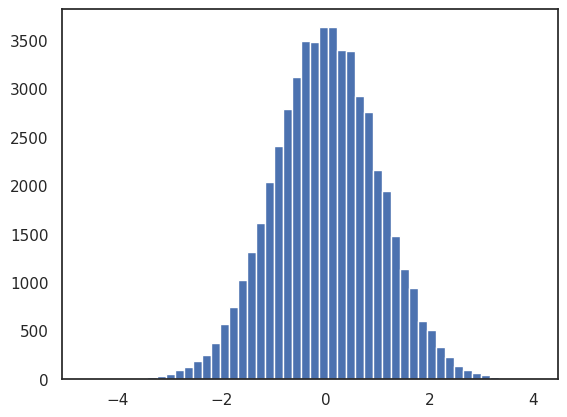

In [86]:
plt.hist(x[m1,m2, qq, noise][:,20], bins = 50)

In [31]:
#try FS with 2+3 prong information
from keras.layers import Dropout
noise = False
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
qq = "qq"
qqq = "qqq"
feature_dims = 6
scoresdict23 = {}
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        print(m1,m2)
        x_data_23 = np.concatenate([x[m1,m2, qq, noise], x[m1,m2, qqq, noise]])
        y_data_23 = np.concatenate([np.zeros(len(x[m1,m2, qq, noise])), np.ones(len(x[m1,m2, qqq, noise]))])
        X_train_23, X_val_23, Y_train_23, Y_val_23 = train_test_split(x_data_23, y_data_23, test_size=0.5)

        model23 = Sequential()
        model23.add(Dense(256, input_dim=feature_dims, activation='relu'))
        model23.add(Dense(128, activation='relu'))
        model23.add(Dense(64, activation='relu'))
        model23.add(Dense(1, activation='sigmoid'))
        model23.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        myhistory23 = model23.fit(X_train_23, Y_train_23, epochs=1000, validation_data=(X_val_23, Y_val_23),batch_size=1024, callbacks = [es], verbose = 0)

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [35]:
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        scores = model23(x[m1, m2, qq, False]).numpy()
        fpr_parametrized, tpr_parametrized, _ = metrics.roc_curve(, preds_parametrized)
        tuples_rates_parametrized[tuple((m1, m2))] = [fpr_parametrized, tpr_parametrized]
    np.save(f"tuples_rates_parametrized_{model_name}{noise_dims}.npy", tuples_rates_parametrized)

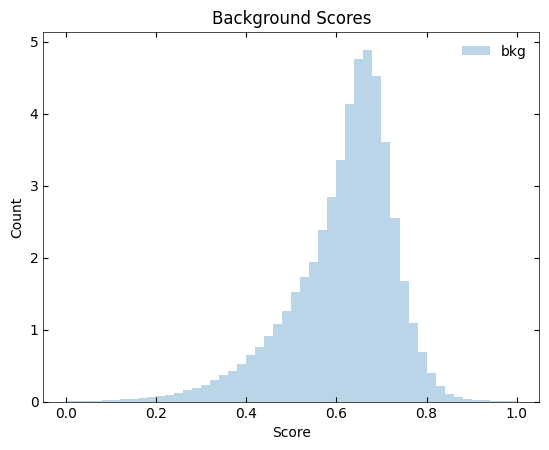

In [47]:
plt.hist(model23(x[0, 0, qq, False]).numpy().flatten(), bins = 50, alpha = 0.3, density=True, label="bkg");
#plt.hist(model23(x[0, 0, qqq, False]).numpy().flatten(), bins = 50, alpha = 0.3, density=True, label="bkg");
plt.legend(loc="upper right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.xlabel("Score")
plt.ylabel("Count")
plt.title(f"Background Scores")
plt.show()

In [50]:
features = np.shape(x[5, 1, qq, False])

In [118]:
model23(x[0, 0, qq, False]).numpy().flatten()

array([0.44268706, 0.4803168 , 0.53578615, ..., 0.48465863, 0.6525794 ,
       0.6320286 ], dtype=float32)

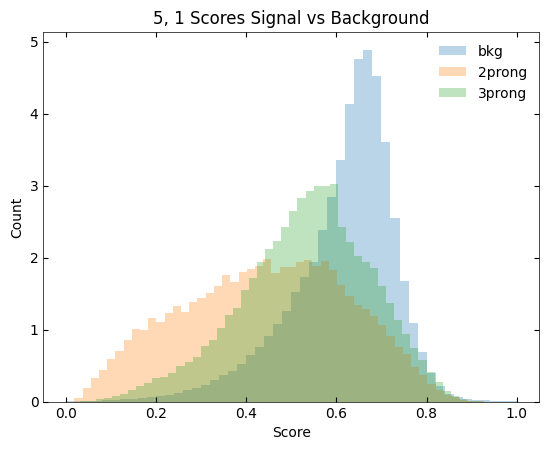

In [45]:
plt.hist(model23(x[0, 0, qq, False]).numpy().flatten(), bins = 50, alpha = 0.3, density=True, label="bkg");
plt.hist(model23(x[5, 1, qq, False]).numpy().flatten(), bins = 50, alpha = 0.3, density=True, label="2prong");
plt.hist(model23(x[5, 1, qqq, False]).numpy().flatten(), bins = 50, alpha = 0.3, density=True, label="3prong");
plt.legend(loc="upper right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.xlabel("Score")
plt.ylabel("Count")
plt.title(f"5, 1 Scores Signal vs Background")
plt.show()


In [86]:
model23(x[3, 3, qq, False][0].reshape(1, 6))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6976464]], dtype=float32)>

In [45]:
len(model23.predict(X_val_23))

1716/1716 [==============================] - 1s 657us/step


54900

In [36]:
import pickle
with open('scoresdict23.pkl', 'wb') as f:
    pickle.dump(scoresdict23, f)

In [37]:
scoresdict23.keys()

dict_keys([(0, 0), (0.5, 0.5), (0.5, 1), (0.5, 1.5), (0.5, 2), (0.5, 2.5), (0.5, 3), (0.5, 3.5), (0.5, 4), (0.5, 4.5), (0.5, 5), (0.5, 5.5), (0.5, 6), (1, 0.5), (1, 1), (1, 1.5), (1, 2), (1, 2.5), (1, 3), (1, 3.5), (1, 4), (1, 4.5), (1, 5), (1, 5.5), (1, 6), (1.5, 0.5), (1.5, 1), (1.5, 1.5), (1.5, 2), (1.5, 2.5), (1.5, 3), (1.5, 3.5), (1.5, 4), (1.5, 4.5), (1.5, 5), (1.5, 5.5), (1.5, 6), (2, 0.5), (2, 1), (2, 1.5), (2, 2), (2, 2.5), (2, 3), (2, 3.5), (2, 4), (2, 4.5), (2, 5), (2, 5.5), (2, 6), (2.5, 0.5), (2.5, 1), (2.5, 1.5), (2.5, 2), (2.5, 2.5), (2.5, 3), (2.5, 3.5), (2.5, 4), (2.5, 4.5), (2.5, 5), (2.5, 5.5), (2.5, 6), (3, 0.5), (3, 1), (3, 1.5), (3, 2), (3, 2.5), (3, 3), (3, 3.5), (3, 4), (3, 4.5), (3, 5), (3, 5.5), (3, 6), (3.5, 0.5), (3.5, 1), (3.5, 1.5), (3.5, 2), (3.5, 2.5), (3.5, 3), (3.5, 3.5), (3.5, 4), (3.5, 4.5), (3.5, 5), (3.5, 5.5), (3.5, 6), (4, 0.5), (4, 1), (4, 1.5), (4, 2), (4, 2.5), (4, 3), (4, 3.5), (4, 4), (4, 4.5), (4, 5), (4, 5.5), (4, 6), (4.5, 0.5), (4.5, 1),

In [45]:
len(scoresdict23[(5, 1)]) == len(x[5, 1, qq, False])

True

In [ ]:
#FS with noise dimensions comparison
from keras.layers import Dropout

noise_dims_list = [0, 5, 10]

for dim in noise_dims_list:
    noise_dims = dim
    x = load_data("/pscratch/sd/g/gupsingh/x_array_fixed_EXTRAQCD.pkl", noise_dims = noise_dims)

    preds_mm_list = []
    tuple_rates_dedicated_benchmark_extra = {}
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    qq = "qq"

    if noise_dims == 0:
        noise = False
    else:
        noise = True
    print(noise)
    feature_dims = 6 + noise_dims
    for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:
            if (m1 == 5 and m2 == 1):
                x_data_mm = np.concatenate([x[0,0, qq, noise],x[m1,m2, qq, noise]])
                y_data_mm = np.concatenate([np.zeros(len(x[0,0, qq, noise])),np.ones(len(x[m1,m2, qq, noise]))])
                X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_data_mm, y_data_mm, test_size=0.5)

                model = Sequential()
                model.add(Dense(256, input_dim=feature_dims, activation='relu'))
                model.add(Dropout(0.5))
                model.add(Dense(128, activation='relu'))
                model.add(Dropout(0.5))
                model.add(Dense(64, activation='relu'))
                model.add(Dense(1, activation='sigmoid'))
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

                myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

                preds_mm = model.predict(X_val_mm,batch_size=1000)
                fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

                preds_mm_list.append(preds_mm)
                tuple_rates_noise[tuple((m1, m2))] = [fpr_mm, tpr_mm]

                plt.plot(tuple_rates_noise[(m1,m2)][1], 1./(tuple_rates_noise[(m1,m2)][0]), label = f"{noise_dims}", linewidth = 1)
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("True Positive Rate")
plt.ylabel("Background Rejection $\\frac{1}{FPR}$")
plt.title(f"$({5*100}, {1*100})$ GeV Dedicated Noise Dimensions")
sns.set(style="white")
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.show()

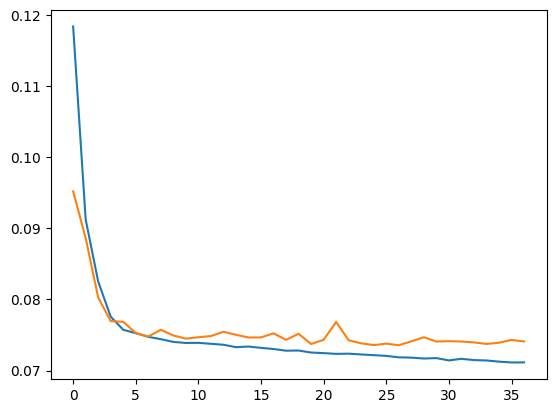

In [5]:
epochs = [x for x in range(len(myhistory_noise.history["loss"]))]
plt.plot(epochs, myhistory_noise.history["loss"])
plt.plot(epochs, myhistory_noise.history["val_loss"])

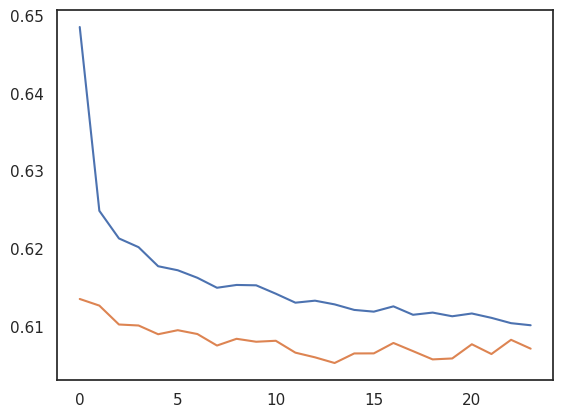

In [22]:
epochs = [x for x in range(len(myhistory23.history["loss"]))]
plt.plot(epochs, myhistory23.history["loss"])
plt.plot(epochs, myhistory23.history["val_loss"])

In [6]:
def calculate_auc(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]
    
    auc = np.trapz(tpr_sorted, fpr_sorted)
    return auc

# preds_qqq = model23.predict(X_val_mm,batch_size=1000)
# fpr_qqq, tpr_qqq, _ = metrics.roc_curve(Y_val_mm, preds_qqq)
# plt.plot(fpr_qqq, tpr_qqq)
# auc = calculate_auc(fpr_qqq, tpr_qqq)
# print("AUC:", auc)

In [ ]:
preds_qqq = model23.predict(x[5,1,qq, noise],batch_size=1000)
fpr_qqq, tpr_qqq, _ = metrics.roc_curve(y_data_qqq[np.prod(x_data_qqq[:,6:8]==[5,1],axis=1)==1], preds_qqq)
plt.plot(fpr_qqq, tpr_qqq)
auc = calculate_auc(fpr_qqq, tpr_qqq)
print("AUC:", auc)

In [53]:
np.shape(x_data_qqq[np.prod(x_data_qqq[:,6:8]==[5,1],axis=1)==1][:, :6])

(793548, 6)

/tmp/ipykernel_2137181/124085034.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tuple_rates_23[(m1,m2)][1], 1./(tuple_rates_23[(m1,m2)][0]), label = f"{m1*100}, {m2*100} GEV")


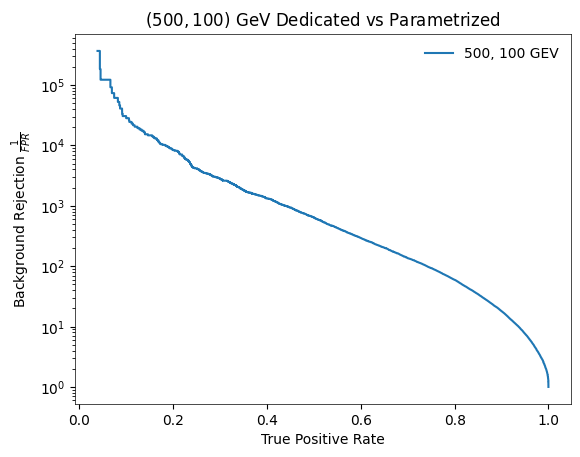

In [33]:
m1, m2 = 5, 1
plt.plot(tuple_rates_23[(m1,m2)][1], 1./(tuple_rates_23[(m1,m2)][0]), label = f"{m1*100}, {m2*100} GEV")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("True Positive Rate")
plt.ylabel("Background Rejection $\\frac{1}{FPR}$")
plt.title(f"$({m1*100}, {m2*100})$ GeV Dedicated vs Parametrized")
#sns.set(style="white")
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.show()

In [14]:
import seaborn as sns
from utils import send_slack_plot 
#epsilon = 1e-4
m1 = 1
m2 = 1

#takes parametrized data corresponding to m1,m2 and replaces it with wrong masses
#then evaluates the data on trained parametrized model
def validation_plot(m1, m2):
    m1_masses_to_try = [1, 3, 3, 4, 6]
    m2_masses_to_try = [2, 3, 4, 5, 6]
    for m1_try, m2_try in zip(m1_masses_to_try, m2_masses_to_try):
        parametrized_data = x_data_qq[np.prod(x_data_qq[:,np.shape(x_data_qq)[1]-2:np.shape(x_data_qq)[1]]==[m1,m2],axis=1)==1]
        parametrized_data[:,np.shape(x_data_qq)[1]-2:np.shape(x_data_qq)[1]]= np.c_[np.ones(len(parametrized_data)) * m1_try, np.ones(len(parametrized_data)) * m2_try]
        preds_parametrized = model_qq.predict(parametrized_data,batch_size=1000)
        fpr_all, tpr_all, _ = metrics.roc_curve(y_data_qq[np.prod(x_data_qq[:,16:18]==[m1,m2],axis=1)==1], preds_parametrized)
        plt.plot(tpr_all, 1/ (fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)
        plt.legend()
        plt.title(f"Parametrized Classifier Validation $m_{1}: {m1*100}  m_{2}: {m2*100} GeV$")
        plt.xlabel("True Positive Rate")
        plt.ylabel("Background Rejection $\\frac{1}{FPR}$")
        sns.set(style="white")
        plt.gca().spines['top'].set_linewidth(0.5)
        plt.gca().spines['right'].set_linewidth(0.5)
        plt.gca().spines['bottom'].set_linewidth(0.5)
        plt.gca().spines['left'].set_linewidth(0.5)
        plt.yscale("log")
    img_path = f"plots/validationplot{float(m1)}{float(m2)}.png"
    #plt.savefig(img_path, dpi=450, bbox_inches='tight')
    send_slack_plot(img_path)

validation_plot(m1,m2)

NameError: name 'model_qq' is not defined

In [67]:
np.shape(x_data_qq)

(115500407, 23)

In [52]:
x_data_qq[:,21:23]

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       ...,
       [6. , 6. ],
       [6. , 6. ],
       [6. , 6. ]])

In [29]:
#model_name = "decent-sun-87qq"
#model_name = "breathless-flower-61qqq"
noise_dims = 10
model_name = "robust-river-109qq10"
#model_name = "easy-monkey-107qq_reduced" #15
model_qq = tf.keras.models.load_model(f"/pscratch/sd/g/gupsingh/{model_name}")
def eval_parametrized(model_parametrized):
    preds_parametrized_list = []
    tuples_rates_parametrized = {}
    for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:
            if (m1 == 3 and m2 == 3) or (m1 == 5 and m2 == 1) or (m1 == 1 and m2 == 1) or (m1 == 1 and m2 == 5) or (m1 == 5 and m2 == 5):
                preds_parametrized = model_parametrized.predict(x_data_qq[np.prod(x_data_qq[:,np.shape(x_data_qq)[1]-2:np.shape(x_data_qq)[1]]==[m1,m2],axis=1)==1],batch_size=1000)
                fpr_parametrized, tpr_parametrized, _ = metrics.roc_curve(y_data_qq[np.prod(x_data_qq[:,np.shape(x_data_qq)[1]-2:np.shape(x_data_qq)[1]]==[m1,m2],axis=1)==1], preds_parametrized)

                preds_parametrized_list.append(preds_parametrized)
                tuples_rates_parametrized[tuple((m1, m2))] = [fpr_parametrized, tpr_parametrized]
    np.save(f"tuples_rates_parametrized_{model_name}{noise_dims}.npy", tuples_rates_parametrized)

eval_parametrized(model_qq)

800/800 [==============================] - 1s 806us/step


/tmp/ipykernel_1174923/3587709800.py:22: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tuple_rates_dedicated[(m1,m2)][1], 1./(tuple_rates_dedicated[(m1,m2)][0]), label = f"{m1*100}, {m2*100} GEV")
/tmp/ipykernel_1174923/3587709800.py:23: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tuple_rates_parametrized[(m1, m2)][1], 1./(tuple_rates_parametrized[(m1, m2)][0]),label= f"Parameterized {m1*100} {m2*100} GEV", linestyle='dashed')


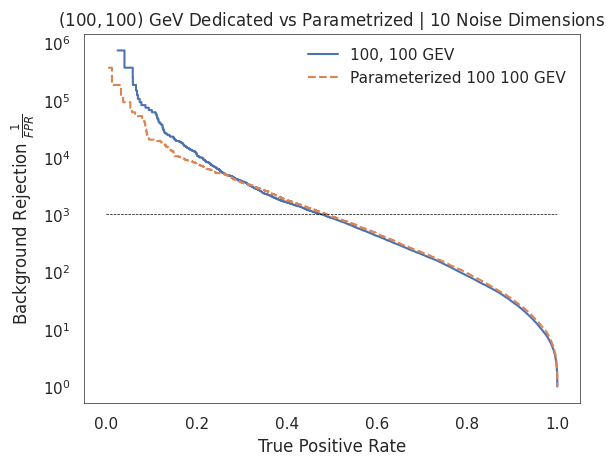

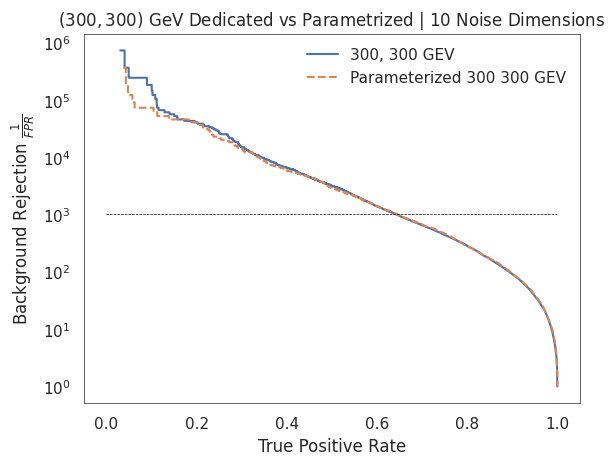

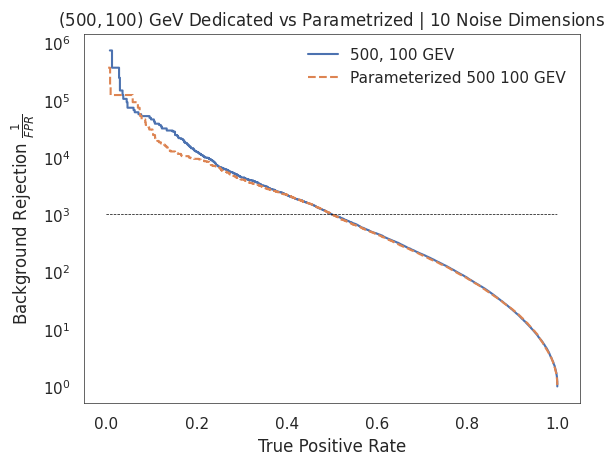

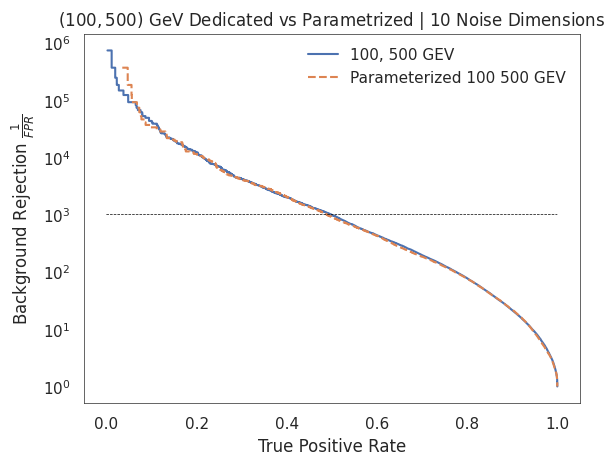

In [12]:
import seaborn as sns
#model_name = "decent-sun-87qq"
noise_dims = 10
model_name= "robust-river-109qq10"
#model_name = "easy-monkey-107qq_reduced"
def plot_comparison(m1, m2):
    fpr_cut = 1e-3
    tuple_rates_parametrized = np.load(f"tuple_rates_dedicated_benchmark_extraqq{noise_dims}.npy", allow_pickle = True).item()
    tuple_rates_dedicated = np.load(f"tuples_rates_parametrized_{model_name}10.npy", allow_pickle = True).item()
    # tuple_rates_parametrized = np.load(f"tuples_rates_parametrized_{model_name}Trueqq.npy", allow_pickle = True).item()
    # tuple_rates_dedicated = np.load("tuple_rates_dedicated_benchmark_extraqqTrue.npy", allow_pickle = True).item()
    
    fpr = tuple_rates_parametrized[(m1,m2)][0]
    tpr = tuple_rates_parametrized[(m1,m2)][1]
    
    index = np.argmin(np.abs(np.array(fpr) - fpr_cut))

    fpr_cut = fpr[index]
    tpr_cut = tpr[index]

    plt.figure()
    plt.plot(tuple_rates_dedicated[(m1,m2)][1], 1./(tuple_rates_dedicated[(m1,m2)][0]), label = f"{m1*100}, {m2*100} GEV")
    plt.plot(tuple_rates_parametrized[(m1, m2)][1], 1./(tuple_rates_parametrized[(m1, m2)][0]),label= f"Parameterized {m1*100} {m2*100} GEV", linestyle='dashed')
    #draw line at fpr cut
    plt.plot(tuple_rates_parametrized[(m1, m2)][1], [1e3] * len(tuple_rates_parametrized[(m1, m2)][1]), linestyle = "--", color = "black", linewidth = 0.5)
    plt.yscale("log")
    plt.legend(frameon=False)
    plt.xlabel("True Positive Rate")
    plt.ylabel("Background Rejection $\\frac{1}{FPR}$")
    plt.title(f"$({m1*100}, {m2*100})$ GeV Dedicated vs Parametrized | {noise_dims} Noise Dimensions")
    sns.set(style="white")
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.show()

plot_comparison(1, 1)
plot_comparison(3, 3)
plot_comparison(5, 1)
plot_comparison(1, 5)

In [13]:
#model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/deep-forest-83qq")
#model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/decent-sun-87qq")
#10 noise dims
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/robust-river-109qq10")

2024-04-03 14:26:04.984876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38384 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-04-03 14:26:04.986563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38384 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-04-03 14:26:04.988131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38384 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2024-04-03 14:26:04.989667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38384 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [27]:
qq = 'qq'
noise = True
feature_dims = 16
# initial_learning_rate = 0.07
# final_learning_rate = 0.07
# decay_steps = 10

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps,
#     decay_rate=tf.math.exp(tf.math.log(final_learning_rate / initial_learning_rate) / decay_steps),
#     staircase=False
# )

weight_list1 = []
weight_list2 = []
weight_list3 = []

max_sic1 = []
max_sic2 = []

epsilon = 1e-4
tuple_rates_semiweak = {}
scoreLossdict = {}

#w1, w2 = np.round(np.random.uniform(0.5, 6.0, size=2),3)
w1, w2 = 0.872, 4.437
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
sigspace = np.logspace(-3.5, -1.3, 10)
test = []
for sigfrac in sigspace:

    #sigfrac = 0.1
    print(w1, w2, sigfrac)

    for l in model_qq.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_regularizer=MinMaxRegularizer())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2),kernel_regularizer=MinMaxRegularizer())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-4))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(feature_dims,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + 0.0001)
    #LLR_xs = 1.+sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+LLR_xs)
    model_semiweak = Model(inputs = inputs, outputs = ws)
    model_semiweak.compile(loss='BCE', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))
    
    print(model_semiweak.trainable_weights[2].numpy()[0][0])

    m1 = 5
    m2 = 1

    test_background = int(1/2 * len(x[0,0, qq, noise]) + 1)
    train_reference = int(1/4 *len(x[0,0, qq, noise]))
    train_data = int(1/4 * len(x[0,0, qq, noise]))
    test_signal = int(1/2*len(x[m1,m2, qq, noise]))

    #fixed signal portion
    N = int(1/4 *len(x[0,0, qq, noise]))
    print(f"Number of 2 Pronged Evengs: {sigfrac * N}")
    signal = x[m1,m2, qq, noise][test_signal:test_signal+int(sigfrac*N)]
    x_data_ = np.concatenate([x[0,0, qq, noise][test_background:],signal])
    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

    myhistory = model_semiweak.fit(X_train_[:,0:feature_dims], Y_train_,
                                         epochs=1000,validation_data=(X_val_[:,0:feature_dims], Y_val_),
                                         batch_size=1024, callbacks = [es], verbose = 0)
    
    w1 = model_semiweak.trainable_weights[0].numpy()[0][0]
    w2 = model_semiweak.trainable_weights[1].numpy()[0][0]
    w3 = model_semiweak.trainable_weights[2].numpy()[0][0]

    print(m1,m2,w1,w2)
    
    weight_list1+=[w1]
    weight_list2+=[w2]
    weight_list3+=[w3]

    print((int(np.round(w1)), int(np.round(w2))))
    if (int(np.round(w1)), int(np.round(w2))) == (m1, m2):
        #if the masses don't swap
        scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
    elif (int(np.round(w1)), int(np.round(w2))) == (m2, m1):
        #if they do swap
        print("Swapped")
        scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m2,m1, qq, noise][0:test_signal]]),batch_size=1024)
    else:
        #if it doesn't get the masses at all (low s/b)
        scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
    
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    max_sic1.append(np.max(tpr/np.sqrt(fpr + epsilon)))
    
    model_CWOLA = compileCWOLA(feature_dims, m1, m2)
    history_CWOLA = model_CWOLA.fit(X_train_[:,0:feature_dims], Y_train_, epochs=1000,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0, callbacks = [es])

    scores2 = model_CWOLA.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    max_sic2.append(np.max(tpr2/np.sqrt(fpr2+epsilon)))

#     scoreLossdict[(sigfrac)] = ((min(myhistory.history["loss"])), scores)
    
#     top_items = sorted(scoreLossdict.values())[:3]
#     lowest_loss_scores = [x[1] for x in top_items]
#     fpr, tpr, _ = metrics.roc_curve(y, np.median(lowest_loss_scores, axis = 0))
#     tuple_rates_semiweak[(sigfrac)] = (fpr, tpr)
#     test.append(np.max(tpr/np.sqrt(fpr + epsilon)))
#     print(test)

0.872 4.437 0.00031622776601683794
-4.0
Number of 2 Pronged Evengs: 58.04423890792264
5 1 0.92730886 5.1740837
(1, 5)
Swapped
387/387 [==============================] - 0s 805us/step
0.92730886 5.1740837 0.0005551935914386209
-4.0
Number of 2 Pronged Evengs: 101.90689409574175



KeyboardInterrupt



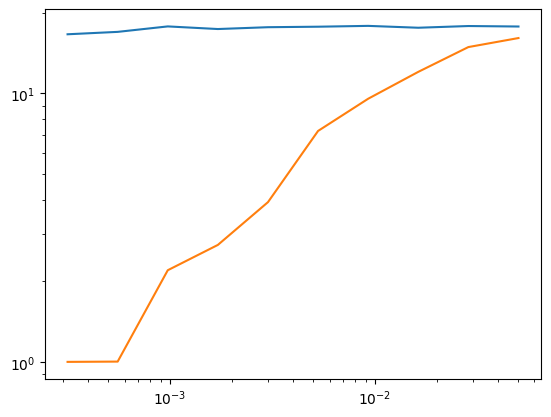

In [52]:
plt.plot(sigspace, max_sic1)
plt.plot(sigspace, max_sic2)
plt.xscale("log")
plt.yscale("log")

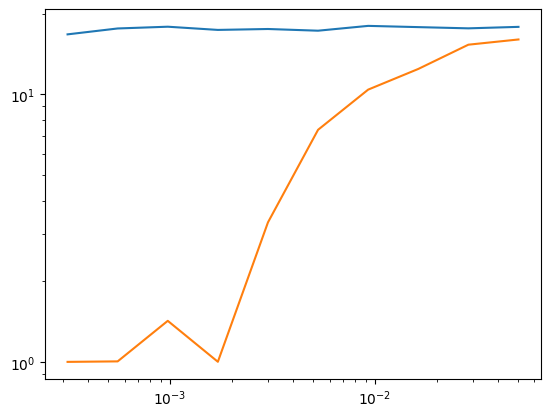

In [45]:
plt.plot(sigspace, max_sic1)
plt.plot(sigspace, max_sic2)
plt.xscale("log")
plt.yscale("log")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


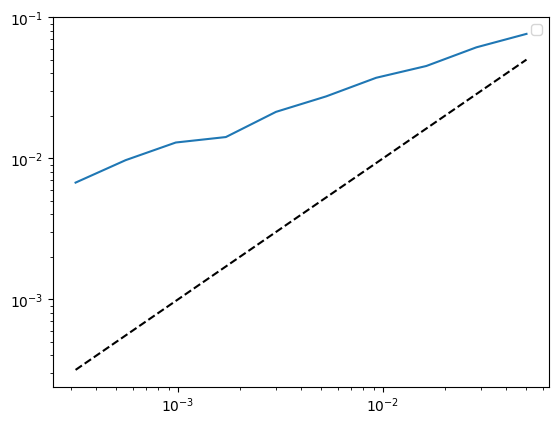

In [54]:
plt.plot(sigspace, np.exp(weight_list3))
plt.legend()
plt.plot(sigspace, sigspace, "--", color = "black")
plt.xscale("log")
plt.yscale("log")

In [19]:
decay = "qqq"
qq = "qq"

sigmoid = lambda x: 1. / (1. + np.exp(-x))

msic1_runs = []
msic2_runs = []
msic3_runs = []
weight_list3_runs = []
weight_list4_runs = []
initial_weights_list_runs = []

num_runs = 1

for _ in range(num_runs):
    
    msic1 = []
    msic2 = []
    msic3 = []
    weight_list1 = []
    weight_list2 = []
    weight_list3 = []
    weight_list4 = []

    sigspace = np.logspace(-3, -1, 10)

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    initial_weights_list_runs.append((w1, w2))

    for sigfrac in sigspace:

        #freeze both two pronged and three pronged prior models
        for l in model_qq.layers:
            l.trainable=False

        for l in model_qqq.layers:
            l.trainable=False

        print(sigfrac, w1, w2)

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs_hold4 = tf.keras.Input(shape=(1,))
        simple_model4 = Dense(1,use_bias = False,activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(1.))(inputs_hold4)
        model34 = Model(inputs = inputs_hold4, outputs = simple_model4)

        inputs = tf.keras.Input(shape=(6,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_qq(inputs2)
        hidden_layer_13 = model_qqq(inputs2)
        LLR2 = hidden_layer_1 / (1.-hidden_layer_1+0.0001)
        LLR3 = hidden_layer_13 / (1.-hidden_layer_13+0.0001)
        #LLR_xs = 1.+ sigfrac*LLR3 - sigfrac
        LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0])
        ws = LLR_xs_fixed / (1.+LLR_xs_fixed+0.0001)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 1
        m2 = 5.5

        test_background = int(1/2 * len(x[0,0, decay, noise]))
        train_reference = int(1/4 *len(x[0,0, decay, noise]))
        train_data = int(1/4 * len(x[0,0, decay, noise]))
        test_signal = int(1/2*len(x[m1,m2, decay, noise]))

        #randomize signal events
        # random_test_signal_length = random.randint(0, test_signal - 1)
        N = int(1/4 * (len(x[0,0, decay, noise])))
        # signal = x[m1, m2, decay][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        #mix both samples
        signal_mixed = np.concatenate([x[m1, m2, decay, noise][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))], x[m1, m2, qq, noise][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))]])
        background_mixed = np.concatenate([x[0,0,decay, noise][:int(test_background/2)], x[0,0,qq, noise][:int(test_background/2)]])
        
        # x_data_ = np.concatenate([x[0,0,decay][test_background:],signal])
        # y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])
        
        x_data_mixed = np.concatenate([background_mixed,signal_mixed])
        y_data_mixed = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal_mixed))])
        
        #noise?
        # samples = np.shape(x_data_mixed)[0]
        # random_samples = np.random.normal(0, 1, samples)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_mixed, y_data_mixed, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

        weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
        weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
        weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        weight_list4+=[sigmoid(model_all2.trainable_weights[3].numpy()[0][0])]

NameError: name 'model_qqq' is not defined

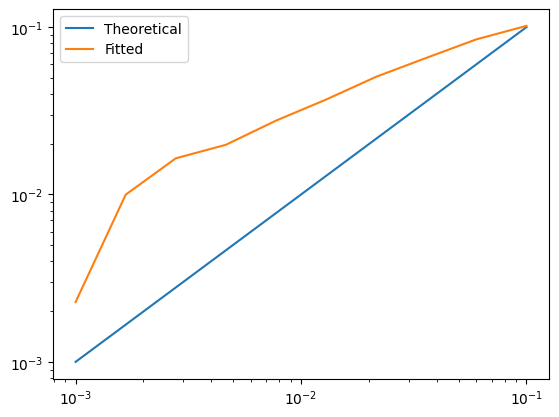

In [15]:
sigspace = np.logspace(-3, -1, 10)
plt.plot(sigspace, sigspace, label = "Theoretical")
plt.plot(sigspace, np.exp(weight_list3), label = "Fitted")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

(0.0, 700.0)

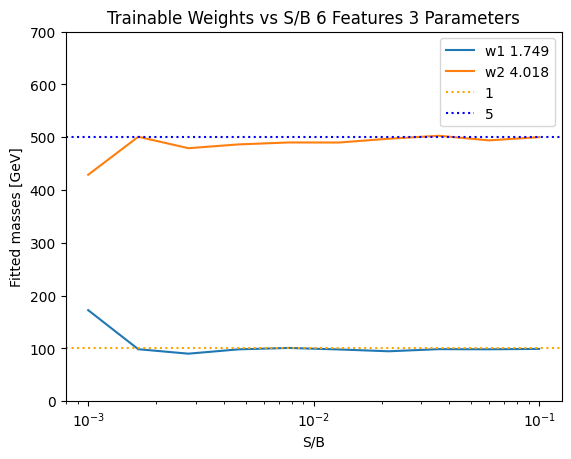

In [20]:
plt.plot(sigspace,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sigspace,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs S/B 6 Features 3 Parameters")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

In [7]:
#dedicated training on single mass pair
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

def train_supervised(feature_dims, m1, m2, fpr_cut = 1e-3):
    epsilon = 1e-4
    x_data_full = np.concatenate([x[0,0, qq, noise],x[m1,m2, qq, noise]])
    y_data_full = np.concatenate([np.zeros(len(x[0,0, qq, noise])),np.ones(len(x[m1,m2, qq, noise]))])
    X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(x_data_full, y_data_full, test_size=0.5, random_state = 42)

    model_dedicated = Sequential()
    model_dedicated.add(Dense(256, input_dim=feature_dims, activation='relu'))
    model_dedicated.add(Dense(128, activation='relu'))
    model_dedicated.add(Dense(64, activation='relu'))
    model_dedicated.add(Dense(1, activation='sigmoid'))
    model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

    history_fullySupervised = model_dedicated.fit(X_train_full, Y_train_full, epochs=1000,validation_data=(X_val_full, Y_val_full),batch_size=1024, verbose = 0, callbacks = [es])
    preds = model_dedicated.predict(X_val_full,batch_size=1024)
    fpr, tpr, _ = metrics.roc_curve(Y_val_full, preds)
    adjusted_fpr = np.maximum(fpr, fpr_cut)
    maxsic = np.max(tpr / np.sqrt(adjusted_fpr + epsilon))
    return maxsic

#CWOLA comparison
def compileCWOLA(feature_dims, m1, m2):
    model_cwola = Sequential()
    model_cwola.add(Dense(256, input_dim=feature_dims, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
    return model_cwola

class MinMaxRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self):
        self.min_val = 0.5
        self.max_val = 6
        self.l = 1

    def __call__(self, x):
        x_under = tf.cast(tf.less(x, self.min_val), dtype=tf.float32)
        x_over  = tf.cast(tf.greater(x, self.max_val), dtype=tf.float32)
        under_penalty = (tf.exp(self.min_val - x) - 1)
        over_penalty = (tf.exp(x - self.max_val) - 1)
        penalty = self.l * tf.math.reduce_sum(((x_under * under_penalty) + (x_over * over_penalty)))
        return penalty

    def get_config(self):
        return {'l': float(self.l),
              'min_val': float(self.min_val),
              'max_val': float(self.max_val)}

from tensorflow.keras.constraints import Constraint
class WeightConstraint(Constraint):
    def __init__(self, min_value=0.5, max_value=6):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, weights):
        return tf.clip_by_value(weights, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value, 'max_value': self.max_value}

# initial_learning_rate = 0.05
# final_learning_rate = 0.01
# decay_epochs = 50

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_rate=(final_learning_rate / initial_learning_rate) ** (1.0 / decay_epochs),
#     decay_steps=1,
#     staircase=True)

#SemiWeak Model
def compileSemiWeakly(sigfrac, model, feature_dims, params, m1, m2, w1, w2):
    
    for l in model.layers:
        l.trainable=False
        
    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_regularizer=MinMaxRegularizer())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2), kernel_regularizer=MinMaxRegularizer())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-4))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(feature_dims,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    epsilon = 1e-4
    
    #physics prior
    hidden_layer_1 = model(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)

    if params == 2:
        LLR_xs = 1.+sigfrac*LLR - sigfrac
    elif params == 3:
        LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
    else:
        print("Choose 2 or 3 parameters")
    ws = LLR_xs / (1.+LLR_xs)

    SemiWeakModel = Model(inputs = inputs, outputs = ws)
    SemiWeakModel.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.05, clipvalue=0.0001, clipnorm=0.0001))
    return SemiWeakModel

def compileSemiWeakly3Prong(sigfrac, model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2):
    #freeze both two pronged and three pronged prior models
    for l in model_qq.layers:
        l.trainable=False

    for l in model_qqq.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_constraint=WeightConstraint())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2), kernel_constraint=WeightConstraint())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-4))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs_hold4 = tf.keras.Input(shape=(1,))
    simple_model4 = Dense(1,use_bias = False,activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold4)
    model34 = Model(inputs = inputs_hold4, outputs = simple_model4)

    inputs = tf.keras.Input(shape=(7,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    hidden_layer_13 = model_qqq(inputs2)
    LLR2 = hidden_layer_1 / (1.-hidden_layer_1+0.0001)
    LLR3 = hidden_layer_13 / (1.-hidden_layer_13+0.0001)
    
    if parameters == 2:
        LLR_xs = 1.+ sigfrac*LLR3 - sigfrac
    if parameters == 4:
        #LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0])
        LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0]) - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs_fixed / (1.+LLR_xs_fixed+0.0001)
    SemiWeak3Prong = Model(inputs = inputs, outputs = ws)
    SemiWeak3Prong.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.05, clipvalue=0.0001, clipnorm=0.0001))
    return SemiWeak3Prong

In [34]:
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/deep-forest-83qq")
model_qqq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/breathless-flower-61qqq")

model_qqq._name = "model_qqq"
for l in model_qqq.layers:
    l._name = f"{l.name}_model_qqq"

In [46]:
qq = "qq"
qqq = "qqq"
decay = "qqq"
noise = False
sigmoid = lambda x: 1. / (1. + np.exp(-x))
feature_dims = 6
parameters = 4
    
msic1 = []
weight_list1 = []
weight_list2 = []
weight_list3 = []
weight_list4 = []

epsilon = 1e-4

sigspace = np.logspace(-3, -1, 10)
alpha = 0.5
test = []
tuple_rates_semiweak3 = {}
scoreLossdict = {}

w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)
w1,w2 = 2.577, 2.284

for sigfrac in sigspace:
    print(sigfrac, w1, w2)
    
    m1 = 3
    m2 = 3
    
    semiweak_3prong = compileSemiWeakly3Prong(sigfrac, model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2)
    test_background = int(1/2 * len(x[0,0, decay, noise]) + 1)
    train_reference = int(1/4 *len(x[0,0, decay, noise]))
    train_data = int(1/4 * len(x[0,0, decay, noise]))
    test_signal = int(1/2*len(x[m1,m2, decay, noise]))

    #randomize signal events
    # random_test_signal_length = random.randint(0, test_signal - 1)
    N = int(1/4 * (len(x[0,0, decay, noise])))
    print(f"Number of 3 Pronged Evengs: {sigfrac * N *alpha}")
    print(f"Number of 2 Pronged Evengs: {sigfrac * N *(1-alpha)}")
    
    #mix both samples
    signal_mixed = np.concatenate([x[m1, m2, decay, noise][int(test_signal):int(test_signal) + int(sigfrac * N * alpha)], x[m1, m2, qq, noise][int(test_signal):int(test_signal) + int(sigfrac * N * (1-alpha))]])
    x_data_mixed = np.concatenate([x[0,0,decay, noise][test_background:],signal_mixed])
    y_data_mixed = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal_mixed))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_mixed, y_data_mixed, test_size=0.5, random_state = 42)

    history3prong = semiweak_3prong.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
    print(m1,m2,semiweak_3prong.trainable_weights[0].numpy()[0][0],semiweak_3prong.trainable_weights[1].numpy()[0][0])

    weight_list1+=[semiweak_3prong.trainable_weights[0].numpy()[0][0]]
    weight_list2+=[semiweak_3prong.trainable_weights[1].numpy()[0][0]]
    weight_list3+=[np.exp(semiweak_3prong.trainable_weights[2].numpy()[0][0])]
    weight_list4+=[sigmoid(semiweak_3prong.trainable_weights[3].numpy()[0][0])]
    print("Alpha: ", sigmoid(semiweak_3prong.trainable_weights[3].numpy()[0][0]))

0.001 2.577 2.284
Number of 3 Pronged Evengs: 91.776
Number of 2 Pronged Evengs: 91.776
3 3 3.2716954 1.2663624
Alpha:  1.0039839216483812
0.0016681005372000592 2.577 2.284
Number of 3 Pronged Evengs: 153.09159490207264
Number of 2 Pronged Evengs: 153.09159490207264
3 3 2.8061416 2.6279228
Alpha:  1.00076357027677
0.0027825594022071257 2.577 2.284
Number of 3 Pronged Evengs: 255.37217169696117
Number of 2 Pronged Evengs: 255.37217169696117
3 3 3.0667148 2.95991
Alpha:  1.0004534794841298
0.004641588833612777 2.577 2.284
Number of 3 Pronged Evengs: 425.98645679364625
Number of 2 Pronged Evengs: 425.98645679364625
3 3 2.8937972 3.0329034
Alpha:  1.0005109239192256
0.007742636826811269 2.577 2.284
Number of 3 Pronged Evengs: 710.5882374174311
Number of 2 Pronged Evengs: 710.5882374174311
3 3 3.0478215 2.8432403
Alpha:  1.0018831113416269
0.01291549665014884 2.577 2.284
Number of 3 Pronged Evengs: 1185.3326205640599
Number of 2 Pronged Evengs: 1185.3326205640599
3 3 2.9586217 3.1335857
Alp

KeyboardInterrupt: 

(0.0, 700.0)

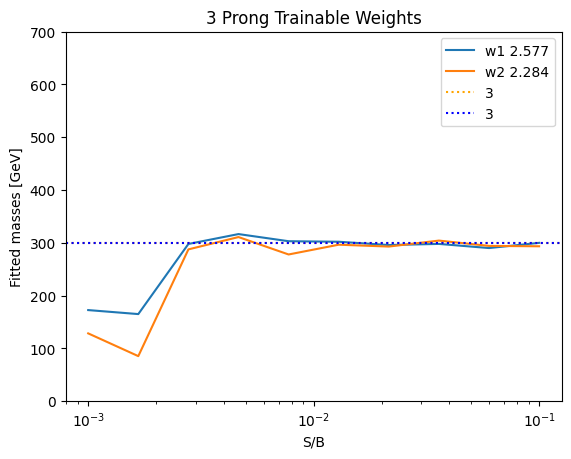

In [36]:
plt.plot(sigspace,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sigspace,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("3 Prong Trainable Weights")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

In [21]:
decay = "qqq"
qq = "qq"
noise = False
sigmoid = lambda x: 1. / (1. + np.exp(-x))

msic1_runs = []
msic2_runs = []
msic3_runs = []
weight_list3_runs = []
weight_list4_runs = []
initial_weights_list_runs = []

num_runs = 1

for _ in range(num_runs):
    
    msic1 = []
    msic2 = []
    msic3 = []
    weight_list1 = []
    weight_list2 = []
    weight_list3 = []
    weight_list4 = []

    sigspace = np.logspace(-3, -1, 10)

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    initial_weights_list_runs.append((w1, w2))

    #print(w1, w2)
    for sigfrac in sigspace:

        #freeze both two pronged and three pronged prior models
        for l in model_qq.layers:
            l.trainable=False

        for l in model_qqq.layers:
            l.trainable=False

        #sigfrac = 0.1
        print(sigfrac, w1, w2)

        #w1, w2 = 3.241, 3.649 

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-4))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs_hold4 = tf.keras.Input(shape=(1,))
        simple_model4 = Dense(1,use_bias = False,activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(1.))(inputs_hold4)
        model34 = Model(inputs = inputs_hold4, outputs = simple_model4)

        inputs = tf.keras.Input(shape=(6,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_qq(inputs2)
        hidden_layer_13 = model_qqq(inputs2)
        LLR2 = hidden_layer_1 / (1.-hidden_layer_1+0.0001)
        LLR3 = hidden_layer_13 / (1.-hidden_layer_13+0.0001)
        #LLR_xs = 1.+ sigfrac*LLR3 - sigfrac
        LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0])
        #LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0]) - model33(tf.ones_like(inputs)[:,0])
        ws = LLR_xs_fixed / (1.+LLR_xs_fixed+0.0001)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.03))

        m1 = 5
        m2 = 1

        test_background = int(1/2 * len(x[0,0, decay, noise]))
        train_reference = int(1/4 *len(x[0,0, decay, noise]))
        train_data = int(1/4 * len(x[0,0, decay, noise]))
        test_signal = int(1/2*len(x[m1,m2, decay, noise]))

        #randomize signal events
        # random_test_signal_length = random.randint(0, test_signal - 1)
        N = int(1/4 * (len(x[0,0, decay, noise])))
        # signal = x[m1, m2, decay][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        #mix both samples
        signal_mixed = np.concatenate([x[m1, m2, decay, noise][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))], x[m1, m2, qq, noise][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))]])
        background_mixed = np.concatenate([x[0,0,decay, noise][:int(test_background/2)], x[0,0,qq, noise][:int(test_background/2)]])
        
        # x_data_ = np.concatenate([x[0,0,decay][test_background:],signal])
        # y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])
        
        x_data_mixed = np.concatenate([background_mixed,signal_mixed])
        y_data_mixed = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal_mixed))])
        
        #noise?
        # samples = np.shape(x_data_mixed)[0]
        # random_samples = np.random.normal(0, 1, samples)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_mixed, y_data_mixed, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

        weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
        weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
        weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        weight_list4+=[sigmoid(model_all2.trainable_weights[3].numpy()[0][0])]


0.001 4.309 2.601
5 1 4.481281 3.0272634
0.0016681005372000592 4.309 2.601
5 1 3.8599396 2.323116
0.0027825594022071257 4.309 2.601
5 1 4.2938533 3.004403
0.004641588833612777 4.309 2.601
5 1 4.247781 2.84452
0.007742636826811269 4.309 2.601
5 1 4.5453434 2.901943
0.01291549665014884 4.309 2.601
5 1 4.149795 2.8199232
0.021544346900318832 4.309 2.601
5 1 4.518403 2.7993476
0.03593813663804626 4.309 2.601
5 1 4.999776 2.5269625
0.05994842503189409 4.309 2.601
5 1 4.9156704 0.94713557
0.1 4.309 2.601
5 1 4.9616027 1.0014924


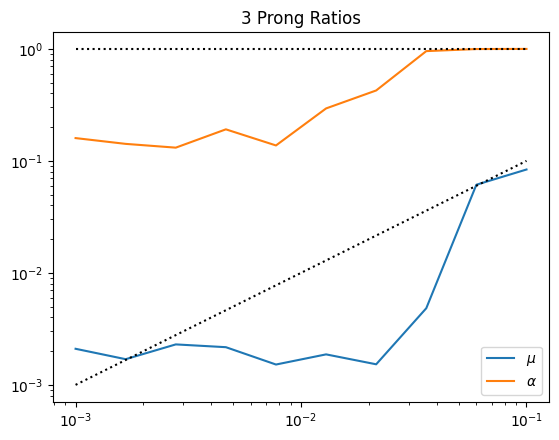

In [22]:
plt.plot(sigspace, weight_list3,label=r"$\mu$")
plt.plot(sigspace, np.array(weight_list4),label=r"$\alpha$")
plt.plot(sigspace, sigspace,ls=":",color="black")
plt.plot(sigspace, [1] * 10, ls = ":", color = "black")
plt.title("3 Prong Ratios")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [6]:
#Loop over signal injection amounts M
#For a given signal injection amount, inject events according to N ~ Poission(M)
#For a given N injected events, initialize the network with w ~ Uniform.  Do this k times.
from utils import get_stuck_weights

noise = False
epsilon = 1e-4
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model_name = "decent-sun-87qq"
#model_name = "robust-river-109qq10"
model_name = "23prong"
#model_qq = tf.keras.models.load_model(f"/pscratch/sd/g/gupsingh/{model_name}")

# model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/deep-forest-83qq")
# model_qqq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/breathless-flower-61qqq")

# model_qqq._name = "model_qqq"
# for l in model_qqq.layers:
#     l._name = f"{l.name}_model_qqq"

model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/revived-fog-121qq023")
model_qqq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/pious-bee-128qqq023")

model_qqq._name = "model_qqq"
for l in model_qqq.layers:
    l._name = f"{l.name}_model_qqq"
    
def train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations, decay = "qq"):
    maxsicandstd1 = {}
    maxsicandstd2 = {}
    msic1_runs = []
    msic2_runs = []
    std1_runs = []
    std2_runs = []
    score1_injections_raw_runs = []
    score2_injections_raw_runs = []
    weight_list1_runs = []
    weight_list2_runs = []
    weight_list3_runs = []
    weight_list4_runs = []
    initial_weights_runs = []
    tuple_rates_semiweak = {}
    tuple_rates_weak = {}

    qq = "qq"
    qqq = "qqq"
    alpha = 0.2
    test_signal = int(1/2*len(x[m1,m2, qq, noise]))

    sigspace = np.logspace(-3.5, -1.3, 10)
    for sigfrac in sigspace:
        print(f"At {sigfrac} for decay {decay}")

        initial_weights = []

        msic1_median = []
        msic2 = []
        score1_injections = []
        score2_injections = []
        weight_list1_injections = []
        weight_list2_injections = []
        weight_list3_injections = []
        weight_list4_injections = []

        print(f"---------------{sigfrac}---------------")

        # N ~ Poission(M) injected events
        for injection in range(injections):
            print(f"Injecting N = {injections - injection} more times, currently on: N = {injection}")

            #randomized signal
            random_test_signal_length = random.randint(0, test_signal - 1)
            N = int(1/4 * (len(x[0,0, qq, noise])))
            signal = x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

            score1_kruns = []
            weight_list1_kruns = []
            weight_list2_kruns = []
            weight_list3_kruns = []
            weight_list4_kruns = []
            scoreLossdict = {}

            print(f"Ensembling {m_initializations} for Signal Fraction : {sigfrac}")
            for k in range(m_initializations):

                w1 = round(random.uniform(0.5, 6),3)
                w2 = round(random.uniform(0.5, 6),3)
                initial_weights.append((w1, w2))

                print(f"Initialization: {w1} {w2}")
                
                test_background = int(1/2 * len(x[0,0, qq, noise])+1)
                train_reference = int(1/4 *len(x[0,0, qq, noise]))
                train_data = int(1/4 * len(x[0,0, qq, noise]))
                test_signal = int(1/2*len(x[m1,m2, qq, noise]))

                if decay == "qq":
                    model_semiweak = compileSemiWeakly(sigfrac, model_qq, feature_dims, parameters, m1, m2, w1, w2)
                    
                    x_data_ = np.concatenate([x[0,0, qq, noise][test_background:],signal])
                    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])
                    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

                if decay == "qqq":
                    model_semiweak = compileSemiWeakly3Prong(sigfrac, model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2)
                    
                    print(f"Number of 3 Pronged Evengs: {sigfrac * N *alpha}")
                    print(f"Number of 2 Pronged Evengs: {sigfrac * N *(1-alpha)}")

                    #mix both samples
                    signal_mixed = np.concatenate([x[m1, m2, decay, noise][int(random_test_signal_length):int(random_test_signal_length) + int(sigfrac * N * alpha)], x[m1, m2, qq, noise][int(random_test_signal_length):int(random_test_signal_length) + int(sigfrac * N * (1-alpha))]])

                    x_data_mixed = np.concatenate([x[0,0, qq, noise][test_background:],signal_mixed])
                    y_data_mixed = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal_mixed))])

                    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_mixed, y_data_mixed, test_size=0.5, random_state = 42)

                history_semiweak = model_semiweak.fit(X_train_[:,0:feature_dims], Y_train_, epochs=1000,
                                                          validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0, callbacks = [es])

                print(f"m1: {m1}",f"m2: {m2}", f"w1: {model_semiweak.trainable_weights[0].numpy()[0][0]}", f"w2: {model_semiweak.trainable_weights[1].numpy()[0][0]}")

                weight_list1_kruns+=[model_semiweak.trainable_weights[0].numpy()[0][0]]
                weight_list2_kruns+=[model_semiweak.trainable_weights[1].numpy()[0][0]]
                weight_list3_kruns+=[model_semiweak.trainable_weights[2].numpy()[0][0]]

                if decay == "qqq":
                    weight_list4_kruns+=[model_semiweak.trainable_weights[3].numpy()[0][0]]
                
                if (int(np.round(w1)), int(np.round(w2))) == (m1, m2):
                    #if correct order don't swap
                    scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
                elif (int(np.round(w1)), int(np.round(w2))) == (m2, m1):
                    #if swapped evaluate with swapped masses
                    print("Swapped")
                    scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m2,m1, qq, noise][0:test_signal]]),batch_size=1024)
                else:
                    #if it doesn't get the masses at all (low s/b)
                    scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
                score1_kruns.append(scores)
                scoreLossdict[(min(history_semiweak.history["loss"]))] = scores
                #scoreLossdict[(sigfrac, injections, k)] = ((min(history_semiweak.history["loss"])), scores)
            
            #kruns finished
            weight_list1_injections.append(weight_list1_kruns)
            weight_list2_injections.append(weight_list2_kruns)
            weight_list3_injections.append(weight_list3_kruns)
            if decay == "qqq":
                weight_list4_injections.append(weight_list4_kruns)

            #now average over the k classifiers runs
            y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])

            #get the lowest scores from dictionary of losses and scores
            top_items = sorted(scoreLossdict.items())[:3]
            lowest_losses = [x[0] for x in top_items]
            top_scores = [scoreLossdict[loss] for loss in lowest_losses]
            fpr, tpr, _ = metrics.roc_curve(y, np.median(top_scores, axis = 0))
            tuple_rates_semiweak[(sigfrac, injection)] = (fpr, tpr)

            epsilon = 1e-4

            msic1_kmedian = np.max(tpr/np.sqrt(fpr+epsilon))
            score1_injections.append(score1_kruns)
            msic1_median.append(msic1_kmedian)
            print(f" --- msic1_median on injection {injection}: {msic1_kmedian} ---")

            #weakly supervised only inject no k classifiers (out of mass initialization loop) no averaging to be done yet
            model_CWOLA = compileCWOLA(feature_dims, m1, m2)
            history_CWOLA = model_CWOLA.fit(X_train_[:,0:feature_dims], Y_train_, epochs=1000,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0, callbacks = [es])

            scores2 = model_CWOLA.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
            score2_injections.append(scores2)

            y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
            fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
            msic2.append(np.max(tpr2/np.sqrt(fpr2+epsilon)))
            tuple_rates_weak[(sigfrac, injection)] = (fpr2, tpr2)

        msic1_runs.append(np.median(msic1_median))
        print(f" --- msic1_runs for signal fraction {sigfrac}: {np.median(msic1_median)} ---")
        std1_runs.append(np.std(msic1_median))
        print(f" --- msic1_runs_std for signal fraction {sigfrac}: {np.std(msic1_median)} ---")

        print(f" --- msic2_runs for signal fraction {sigfrac}: {np.median(msic2)} ---")
        std2_runs.append(np.std(msic2))
        print(f" --- msic2_runs_std for signal fraction {sigfrac}: {np.std(msic2)} ---")
        msic2_runs.append(np.median(msic2))

        score1_injections_raw_runs.append(score1_injections)
        score2_injections_raw_runs.append(score2_injections)
        weight_list1_runs.append(weight_list1_injections)
        weight_list2_runs.append(weight_list2_injections)
        weight_list3_runs.append(weight_list3_injections)
        if decay == "qqq":
            weight_list4_runs.append(weight_list4_injections)

        # maxsicandstd1[sigfrac] = (np.median(msic1_median), np.std(msic1_median))
        # maxsicandstd2[sigfrac] = (np.median(msic2), np.std(msic2))
        
        if len(x[0,0, qq, noise]) > 121352:
            extra = True
            
        extra_str = "_extra" if extra else ""
        # np.save(f"data/maxsicandstd1_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", maxsicandstd1)
        # np.save(f"data/maxsicandstd2_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", maxsicandstd2)

    stuck_weights = get_stuck_weights(sigspace, injections, m_initializations, m1, m2, weight_list1_runs, weight_list2_runs, decay)
    np.save(f"data/stuck_weights_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", stuck_weights)
    np.save(f"data/tuplerates_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", tuple_rates_semiweak)
    np.save(f"data/tuplerates2_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", tuple_rates_weak)
    np.save(f"data//scoreLossdict{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", scoreLossdict)

    # np.save(f"data/msic1_median_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", maxsicandstd1)
    # np.save(f"data/msic2_median_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", maxsicandstd2)
    # np.save(f"data/std1_median_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", std1_runs)
    # np.save(f"data/std2_median_notebook{float(m1)}{float(m2)}_{decay}{extra}.npy", std2_runs)
    np.save(f"data/weight_list1_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", weight_list1_runs)
    np.save(f"data/weight_list2_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", weight_list2_runs)
    np.save(f"data/weight_list3_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", weight_list3_runs)

    np.save(f"data/score1_injections_raw_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", score1_injections_raw_runs)
    np.save(f"data/score2_injections_raw_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", score2_injections_raw_runs)
    if decay == "qqq":
        np.save(f"data/weight_list4_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", weight_list4_runs)
    np.save(f"data/initial_weights_runs_{float(m1)}{float(m2)}_{decay}{extra_str}{model_name}.npy", initial_weights_runs)

In [12]:
def get_stuck_weights(sigspace, injections, m_initializations, m1, m2, weight_list1, weight_list2, decay):
    # weight_list1 = np.load(f"data/weight_list1_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", allow_pickle = True)
    # weight_list2 = np.load(f"data/weight_list2_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", allow_pickle = True)
    
    missed = {}

    found_one = 0
    found_both = 0
    found_none = 0

    for sigfrac in range(len(sigspace)):

        for injection in range(injections):

            m1_diff = abs(np.array(np.ones(len(weight_list1[sigfrac][injection]))*m1) - np.array(weight_list1[sigfrac][injection]))
            m2_diff = abs(np.array(np.ones(len(weight_list2[sigfrac][injection]))*m2) - np.array(weight_list2[sigfrac][injection]))

            count = 0
            for diff1, diff2 in zip(m1_diff, m2_diff):
                case1 = diff1 > 0.2 and diff2 > 0.2
                case2 = diff1 < 0.2 and diff2 < 0.2
                case3 = diff1 > 0.2 and diff2 < 0.2 or diff1 < 0.2 and diff2 > 0.2

                if case1:
                    found_none+=1
                    missed[(sigspace[sigfrac], injection)] = (weight_list1[sigfrac][injection][count], weight_list2[sigfrac][injection][count])
                    print(np.array(weight_list1[sigfrac][injection][count]), np.array(weight_list2[sigfrac][injection][count]))
                elif case2:
                    found_both+=1
                elif case3:
                    found_one+=1
                    missed[(sigspace[sigfrac], injection)] = (weight_list1[sigfrac][injection][count], weight_list2[sigfrac][injection][count])
                    print(np.array(weight_list1[sigfrac][injection][count]), np.array(weight_list2[sigfrac][injection][count]))
                count+=1
                
    print(f"Found Both: {found_both}")
    print(f"Found None: {found_none}")
    print(f"Found One: {found_one}")
            
    return missed

In [28]:
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/decent-sun-87qq")
#model_qqq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/pumpkin-strudel-100qqq")
#model_qqq._name = "model_qqq"

In [30]:
import time

def eval_loss_landscape(feature_dims, parameters, m1, m2, step, decay):
    qq = decay
    noise = True
    alpha = 0.5
    model_name = "deft-snow-103qqTrue20"

    # for l in model_qqq.layers:
    #     l._name = f"{l.name}_model_qqq"
    start_time = time.time()
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    
    #if using extra QCD background
    if len(x[0,0,qq, noise]) > 121352:
        extra = True
        
    extra_str = "_extra" if extra else ""
    file_name = f"data/landscapes/z_{feature_dims}_{parameters}_{m1}{m2}_{step}_{decay}{extra_str}_{model_name}_{noise}.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    
    losses_list = []
    epsilon = 1e-4
    sigspace = np.logspace(-3.5, -1.3, 10)
    
    start = 0.5
    end = 6
    step = step

    weight_list = np.arange(start, end + step, step)
    
    for sigfrac in sigspace:
        print("Signal Fraction: ", sigfrac)
        count = 0
        for w1 in weight_list:
            for w2 in weight_list:
                if count % 100 == 0:
                    print(f"reached {w1} {w2}")
                count+=1
                #print(w1, w2)
                
                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                key = (sigfrac, m1, m2, decay)
                if key in z:
                    break
                
                test_background = int(1/2 *len(x[0,0, qq, noise])+1)
                train_background = int(1/4 * len(x[0,0,qq, noise]))
                train_data = int(1/4 * len(x[0,0,qq, noise]))
                train_reference = int(1/4 * len(x[0,0,qq, noise]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq, noise]))

                if decay == "qq":
                    model_qq = tf.keras.models.load_model(f"/pscratch/sd/g/gupsingh/{model_name}")
                    model_semiweak = compileSemiWeakly(sigfrac, model_qq, feature_dims, parameters, m1, m2, w1, w2)
                    
                    #randomize signal events
                    random_test_signal_length = random.randint(0, test_signal_length - 1)
                    N = int(1/4 * (len(x[0,0,qq, noise])))
                    signal = x[m1, m2,qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]
                    
                    x_data_ = np.concatenate([x[0,0,qq, noise][test_background:],signal])
                    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])
                    
                    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)


                if decay == "qqq":
                    model_semiweak = compileSemiWeakly3Prong(model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2)
                    
                    print(f"Number of 3 Pronged Evengs: {sigfrac * N *alpha}")
                    print(f"Number of 2 Pronged Evengs: {sigfrac * N *(1-alpha)}")

                    #mix both samples
                    signal_mixed = np.concatenate([x[m1, m2, decay, noise][int(random_test_signal_length):int(random_test_signal_length) + int(sigfrac * N * alpha)], x[m1, m2, qq, noise][int(random_test_signal_length):int(random_test_signal_length) + int(sigfrac * N * (1-alpha))]])

                    x_data_mixed = np.concatenate([x[0,0, qq, noise][test_background:],signal_mixed])
                    y_data_mixed = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal_mixed))])

                    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_mixed, y_data_mixed, test_size=0.5, random_state = 42)

                with tf.device('/GPU:0'):
                    loss = model_semiweak.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print(f"Loss Landscape for m1 = {m1} and m2 = {m2} already exists for {sigfrac} signal fraction and decay {decay}")
        else:
            z[sigfrac, m1, m2, decay] = losses_list
            losses_list = []
            np.save(file_name, z)
    end_time_total = time.time()

    elapsed_time_total = round(end_time_total - start_time, 3)
    print(f"Total elapsed time: {elapsed_time_total} seconds")

In [ ]:
#from landscapes import eval_loss_landscape
eval_loss_landscape(23, 3, 5, 1, 0.25, "qq")

Dictionary doesn't exist, creating one...
Signal Fraction:  0.00031622776601683794
reached 0.5 0.5
reached 1.5 2.5
reached 2.5 4.5
reached 3.75 0.75
reached 4.75 2.75
reached 5.75 4.75
Time taken: 3188.168 seconds
Signal Fraction:  0.0005551935914386209
reached 0.5 0.5
reached 1.5 2.5
reached 2.5 4.5
reached 3.75 0.75
reached 4.75 2.75
reached 5.75 4.75
Time taken: 6429.011 seconds
Signal Fraction:  0.0009747402255566064
reached 0.5 0.5
reached 1.5 2.5
reached 2.5 4.5
reached 3.75 0.75


In [ ]:
feature_dims = 7
m1 = 3
m2 = 3
parameters = 4
injections = 10
m_initializations = 5
decay = "qqq"
train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations, decay = decay)

At 0.00031622776601683794 for decay qqq
---------------0.00031622776601683794---------------
Injecting N = 10 more times, currently on: N = 0
Ensembling 5 for Signal Fraction : 0.00031622776601683794
Initialization: 3.869 4.117
Number of 3 Pronged Evengs: 11.60884778158453
Number of 2 Pronged Evengs: 46.43539112633812


2024-04-12 00:09:59.132488: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdda8ed8160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-12 00:09:59.132503: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-04-12 00:09:59.141300: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 00:09:59.179557: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
I0000 00:00:1712905799.257728 1930218 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


m1: 3 m2: 3 w1: 5.951425075531006 w2: 5.944266319274902
395/395 [==============================] - 1s 1ms/step
Initialization: 0.644 1.527
Number of 3 Pronged Evengs: 11.60884778158453
Number of 2 Pronged Evengs: 46.43539112633812


In [28]:
np.shape(x[0,0,qqq, False])

(734210, 7)